In [1]:
%pylab
%matplotlib inline

import h5py
import pandas as pd
import os
import gc
from scipy import interpolate


#import plotly.express as px
from sklearn.preprocessing import MinMaxScaler,Normalizer,RobustScaler

import Helper_Basic as hbasic
hbasic.set_plot_prop()
plt.ion()

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# Requirement for this script :

## Inputs :
1) H5/csv file with the mechanical data

2) AE catalog (csv) potentially with co-located mechanical data 

## Outputs :

1) Aligned, uniformally spaced, and time aggregated mechanical and AE rate/strain rate/work rate time series 

2) AE event catalog with data appended from the mechanical datasets (e.g. strain rate etc)

# Datafile with the raw deformation datasets & synchronised AE datasets 

a) Specify the path where the mechanical data is stored (in a h5 file)

b) Specify path to the AE data

In [2]:
path_data_folder = '../00_Data/Dry_Basalt/'
path_mechanical_data = path_data_folder+'dry_mechdata.csv'
path_AE_data = path_data_folder+'dry_events_with_mechdata.csv'
name_exp = 'Dry_Basalt'

## Location where the time series data (aggregated) is saved
path_to_save_out_time_series = '/home/tmittal/Causality/Basalt_Data/dataforcausalitytests_' 


### Loading the Mechanical Data

In [3]:
data_def = pd.read_csv(path_mechanical_data)
data_def['date'] = pd.to_datetime(data_def['t_def'])
data_def['time_hr'] = (data_def['date'] - data_def['date'].iloc[0])/ np.timedelta64(3600, 's')
data_def = data_def.set_index('date')

In [4]:
data_def['Time_Since_Step_1'] = (data_def['time_hr'] - 19.491).clip(0)
data_def['Time_Since_Step_2'] = (data_def['time_hr'] - 43.252).clip(0)
data_def['Time_Since_Step_3'] = (data_def['time_hr'] - 66.9255).clip(0)
data_def['Time_Since_Step_4'] = (data_def['time_hr'] - 91.515).clip(0)

In [5]:
dt = np.gradient(data_def.time_hr)
dt_resamp = np.nanmean(dt)
print(dt_resamp)

0.0003256940907758076


In [6]:
new_data_def = data_def.resample(str(int(dt_resamp*3600))+'s',closed='left', label='right').mean().ffill()

In [7]:
print(np.where(new_data_def['Disp_mm'].isna() == True)[0])

[]


In [8]:
new_data_def

Disp_mm  Sig_diff_MPa  Strain_ax     Temp         t_def  \
date                                                                           
2020-01-09 14:39:01  1.49281        6.0958   0.000000  78.1701  1.578581e+18   
2020-01-09 14:39:02  1.49281        6.0958   0.000000  78.2065  1.578581e+18   
2020-01-09 14:39:03  1.49281        6.0958   0.000000  78.1701  1.578581e+18   
2020-01-09 14:39:04  1.49140        6.0958  -0.000018  78.2065  1.578581e+18   
2020-01-09 14:39:05  1.49281        6.0958   0.000000  78.1701  1.578581e+18   
...                      ...           ...        ...      ...           ...   
2020-01-15 11:20:32  5.18593      105.9138   0.047950  80.9728  1.579087e+18   
2020-01-15 11:20:33  5.18593      105.9138   0.047950  81.0456  1.579087e+18   
2020-01-15 11:20:34  5.18451      105.9138   0.047932  80.9728  1.579087e+18   
2020-01-15 11:20:35  5.18451      105.9138   0.047932  81.0092  1.579087e+18   
2020-01-15 11:20:36  5.18593      105.5328   0.047950  81.0820  1.579087e+18   

                        time_hr  Time_Since_Step_1  Time_Since_Step_2  \
date                                                                    
2020-01-09 14:39:01    0.000000           0.000000           0.000000   
2020-01-09 14:39:02    0.000278           0.000000           0.000000   
2020-01-09 14:39:03    0.000556           0.000000           0.000000   
2020-01-09 14:39:04    0.000833           0.000000           0.000000   
2020-01-09 14:39:05    0.001111           0.000000           0.000000   
...                         ...                ...                ...   
2020-01-15 11:20:32  140.691944         121.200944          97.439944   
2020-01-15 11:20:33  140.692222         121.201222          97.440222   
2020-01-15 11:20:34  140.692500         121.201500          97.440500   
2020-01-15 11:20:35  140.692778         121.201778          97.440778   
2020-01-15 11:20:36  140.693056         121.202056          97.441056   

                     Time_Since_Step_3  Time_Since_Step_4  
date                                                       
2020-01-09 14:39:01           0.000000           0.000000  
2020-01-09 14:39:02           0.000000           0.000000  
2020-01-09 14:39:03           0.000000           0.000000  
2020-01-09 14:39:04           0.000000           0.000000  
2020-01-09 14:39:05           0.000000           0.000000  
...                                ...                ...  
2020-01-15 11:20:32          73.766444          49.176944  
2020-01-15 11:20:33          73.766722          49.177222  
2020-01-15 11:20:34          73.767000          49.177500  
2020-01-15 11:20:35          73.767278          49.177778  
2020-01-15 11:20:36          73.767556          49.178056  

[506496 rows x 10 columns]

### Synchronised AE dataset Loading

In [9]:
data = pd.read_csv(path_AE_data)
data['Disp_mm'].interpolate(method='linear',limit_area='inside',inplace=True)
data['Sig_diff_MPa'].interpolate(method='linear',limit_area='inside',inplace=True)
data['Strain_ax'].interpolate(method='linear',limit_area='inside',inplace=True)
data['Temp'].interpolate(method='linear',limit_area='inside',inplace=True)
data['date'] = pd.to_datetime(data['timestamp'])

In [10]:
### Drop AE events with no mechanical data
drop_data_indx = np.where(data['Disp_mm'].isna() != True)[0]
data = data.loc[data.index.isin(drop_data_indx),:].reset_index()

data['time_hr'] = (data['date'] - data_def.index[0])/ np.timedelta64(3600, 's')
data['count'] = np.ones(data['time_hr'].values.shape)
new_data = data.set_index('date')

In [11]:
data

index            timestamp                        evID  Disp_mm  \
0       106  1578580833000000000   2020.009.624033.225633151  1.51828   
1       107  1578580853000000000   2020.009.624053.225653637  1.52536   
2       108  1578580979000000000   2020.009.624259.225779480  1.55790   
3       109  1578580987000000000   2020.009.624307.225787413  1.55790   
4       110  1578581092000000000   2020.009.624452.225892618  1.58337   
...     ...                  ...                         ...      ...   
5360   5466  1579070306000000000  2020.015.1983826.715106760  5.18451   
5361   5467  1579071996000000000  2020.015.1990636.716796490  5.18451   
5362   5468  1579071998000000000  2020.015.1990638.716798597  5.18451   
5363   5469  1579073145000000000  2020.015.1992545.717945520  5.18451   
5364   5470  1579078500000000000  2020.015.2005500.723300795  5.18451   

      Sig_diff_MPa  Strain_ax     Temp                date     time_hr  count  
0           8.7626   0.000331  78.2065 2020-01-09 14:40:33    0.025833    1.0  
1           9.5246   0.000423  78.2065 2020-01-09 14:40:53    0.031389    1.0  
2          13.3344   0.000845  78.2429 2020-01-09 14:42:59    0.066389    1.0  
3          13.3344   0.000845  78.1701 2020-01-09 14:43:07    0.068611    1.0  
4          16.7633   0.001176  78.1701 2020-01-09 14:44:52    0.097778    1.0  
...            ...        ...      ...                 ...         ...    ...  
5360      105.9138   0.047932  80.6817 2020-01-15 06:38:26  135.990556    1.0  
5361      105.9138   0.047932  80.6817 2020-01-15 07:06:36  136.460000    1.0  
5362      105.9138   0.047932  80.6453 2020-01-15 07:06:38  136.460556    1.0  
5363      105.9138   0.047932  80.6817 2020-01-15 07:25:45  136.779167    1.0  
5364      105.9138   0.047932  80.6453 2020-01-15 08:55:00  138.266667    1.0  

[5365 rows x 10 columns]

Text(0, 0.5, 'Orange (AE cumulative), Blue (Diff Stress)')

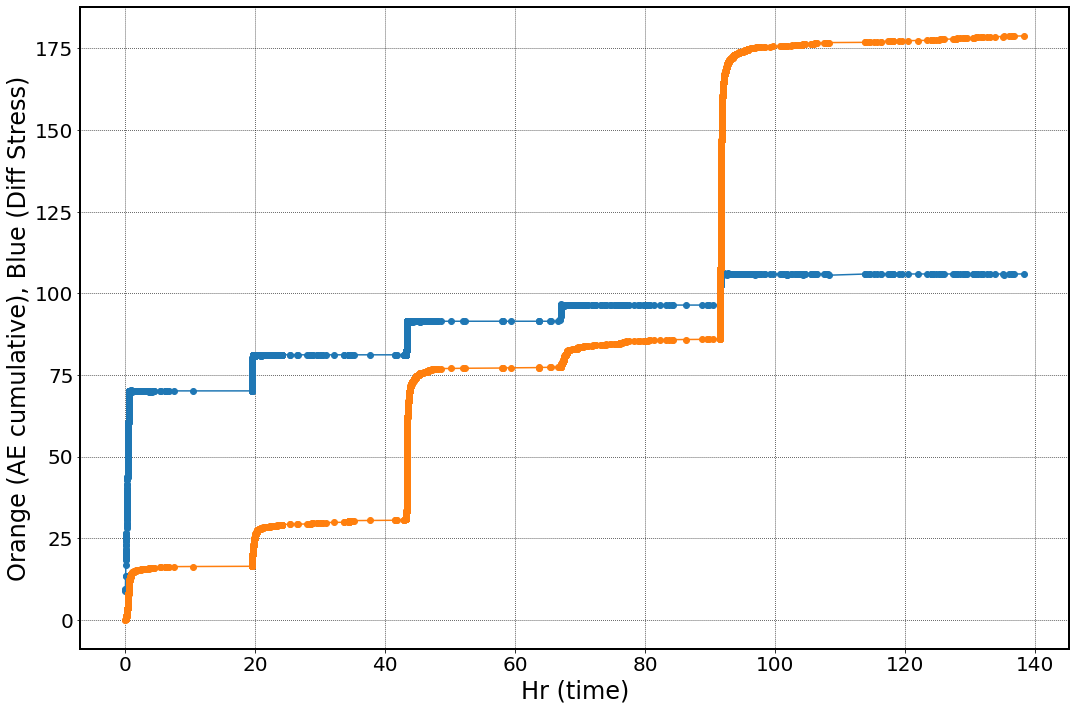

In [12]:
plt.plot(data.time_hr,data.Sig_diff_MPa,'o-')
plt.plot(data.time_hr,np.cumsum(data['count'])/30,'o-')
plt.xlabel('Hr (time)')
plt.ylabel('Orange (AE cumulative), Blue (Diff Stress)')

## Check Synchronization

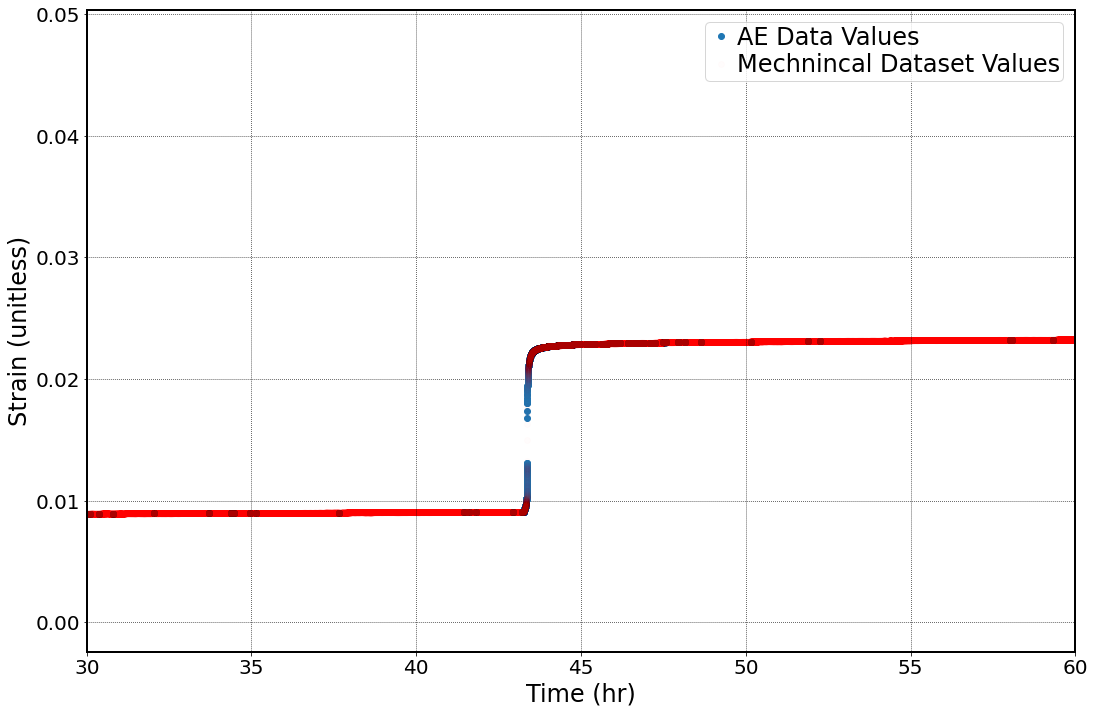

In [13]:
plt.plot(data.time_hr,data.Strain_ax,'o',label='AE Data Values')
plt.plot(data_def.time_hr,data_def.Strain_ax,'ro',alpha=0.01,label='Mechnincal Dataset Values') 
plt.xlim([30,60])
plt.xlabel('Time (hr)')
plt.ylabel('Strain (unitless)')
plt.legend()
#plt.ylim([0.,0.01])

Text(0.5, 0, 'Time (Date)')

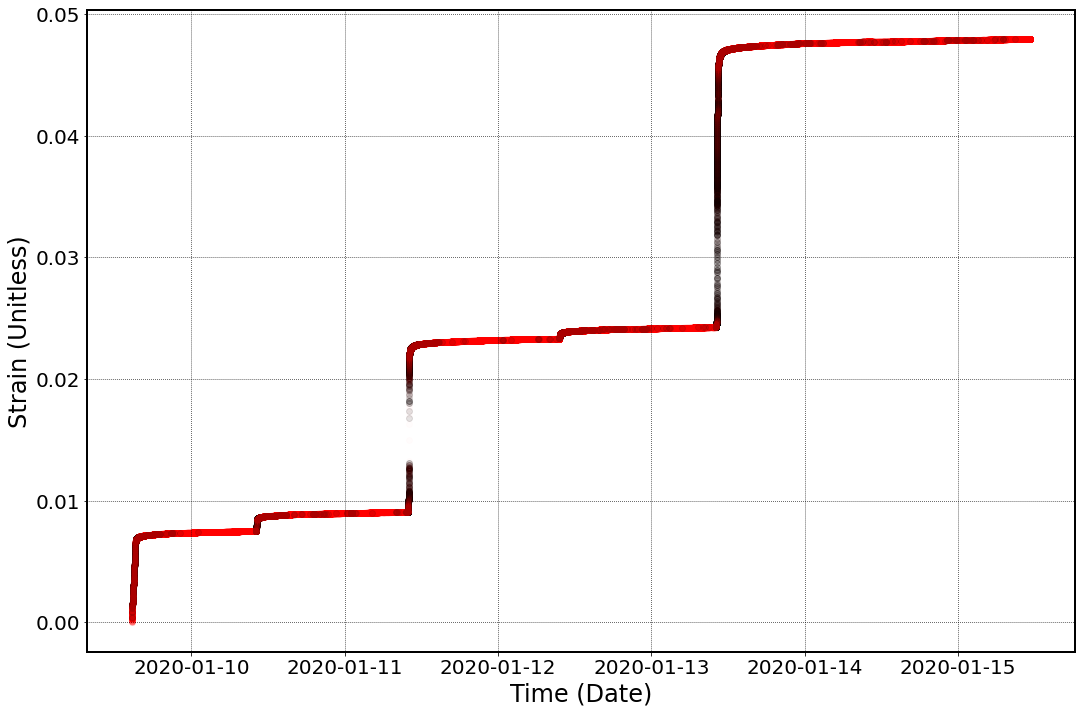

In [14]:
plt.plot(new_data.index,new_data['Strain_ax'],'ko',alpha=.1)
plt.plot(data_def.index,data_def['Strain_ax'],'ro',alpha=0.01)
plt.ylabel('Strain (Unitless)')
plt.xlabel('Time (Date)')
#plt.xlim([np.datetime64('2020-02-19'),np.datetime64('2020-02-20')])
#plt.ylim([0,0.01])
#plt.tight_layout()

### Final Cleaned, Aligned Datasets 

In [15]:
### AE dataset & deformation data with time as the index
# new_data -- AE Data
# new_data_def -- Deformation Data (resampled)

#### Time region cutoff to ensure that both the datasets are comparable

In [16]:
start_date = np.max([new_data_def.index.values[0],new_data.index.values[0]])
end_date = np.min([new_data_def.index.values[-1],new_data.index.values[-1]])
print(f'{start_date}, {end_date}')

2020-01-09T14:40:33.000000000, 2020-01-15T08:55:00.000000000


## Analysis Parts :

a) Make a catalog for the AE data with strain rate etc (extended mechanical catalog)

b) Data plotting with different time aggregations & saving time series for analysis

### Make a time aggregated dataset (mechanical data) to merge with the event catalog

In [17]:
time_window = 60  ## Aggregation Time Window in seconds

In [18]:
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
new_AE_data = pd.merge_asof(new_data, new_data_def_Sampl, left_index = True, right_index = True,
                            direction='forward',tolerance=pd.Timedelta(seconds=time_window),
             suffixes =['','_1min'])
## Note that when we aggregate, the time label is assigned to the end of the time window (right). So, for an event,
#  the relevant data is in the next timestamp (or not relevant - so we have a tolerance) ..

In [19]:
new_AE_data.columns

Index(['index', 'timestamp', 'evID', 'Disp_mm', 'Sig_diff_MPa', 'Strain_ax',
       'Temp', 'time_hr', 'count', 'Disp_mm_1min', 'Sig_diff_MPa_1min',
       'Strain_ax_1min', 'Temp_1min', 't_def', 'time_hr_1min',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'Time_Since_Step_4', 'AE_rate_count', 'strain_rate', 'stress_rate',
       'AE_rate_count_rate', 'Sig_AE_rate', 'strain_rate_AE_rate',
       'strain_AE_rate', 'Sig_strain', 'Sig_strain_rate',
       'Strain_strain_rate'],
      dtype='object')

In [20]:
new_AE_data

index            timestamp                        evID  \
date                                                                          
2020-01-09 14:40:33    106  1578580833000000000   2020.009.624033.225633151   
2020-01-09 14:40:53    107  1578580853000000000   2020.009.624053.225653637   
2020-01-09 14:42:59    108  1578580979000000000   2020.009.624259.225779480   
2020-01-09 14:43:07    109  1578580987000000000   2020.009.624307.225787413   
2020-01-09 14:44:52    110  1578581092000000000   2020.009.624452.225892618   
...                    ...                  ...                         ...   
2020-01-15 06:38:26   5466  1579070306000000000  2020.015.1983826.715106760   
2020-01-15 07:06:36   5467  1579071996000000000  2020.015.1990636.716796490   
2020-01-15 07:06:38   5468  1579071998000000000  2020.015.1990638.716798597   
2020-01-15 07:25:45   5469  1579073145000000000  2020.015.1992545.717945520   
2020-01-15 08:55:00   5470  1579078500000000000  2020.015.2005500.723300795   

                     Disp_mm  Sig_diff_MPa  Strain_ax     Temp     time_hr  \
date                                                                         
2020-01-09 14:40:33  1.51828        8.7626   0.000331  78.2065    0.025833   
2020-01-09 14:40:53  1.52536        9.5246   0.000423  78.2065    0.031389   
2020-01-09 14:42:59  1.55790       13.3344   0.000845  78.2429    0.066389   
2020-01-09 14:43:07  1.55790       13.3344   0.000845  78.1701    0.068611   
2020-01-09 14:44:52  1.58337       16.7633   0.001176  78.1701    0.097778   
...                      ...           ...        ...      ...         ...   
2020-01-15 06:38:26  5.18451      105.9138   0.047932  80.6817  135.990556   
2020-01-15 07:06:36  5.18451      105.9138   0.047932  80.6817  136.460000   
2020-01-15 07:06:38  5.18451      105.9138   0.047932  80.6453  136.460556   
2020-01-15 07:25:45  5.18451      105.9138   0.047932  80.6817  136.779167   
2020-01-15 08:55:00  5.18451      105.9138   0.047932  80.6453  138.266667   

                     count  Disp_mm_1min  ...  AE_rate_count   strain_rate  \
date                                      ...                                
2020-01-09 14:40:33    1.0      1.518116  ...            2.0  0.000000e+00   
2020-01-09 14:40:53    1.0      1.518116  ...            2.0  0.000000e+00   
2020-01-09 14:42:59    1.0      1.549155  ...            1.0  2.024171e-04   
2020-01-09 14:43:07    1.0      1.563962  ...            1.0  1.922466e-04   
2020-01-09 14:44:52    1.0      1.577546  ...            1.0  1.763698e-04   
...                    ...           ...  ...            ...           ...   
2020-01-15 06:38:26    1.0      5.184440  ...            1.0 -1.224790e-06   
2020-01-15 07:06:36    1.0      5.184581  ...            2.0  1.527742e-06   
2020-01-15 07:06:38    1.0      5.184581  ...            2.0  1.527742e-06   
2020-01-15 07:25:45    1.0      5.184557  ...            1.0  6.145590e-07   
2020-01-15 08:55:00    1.0      5.184628  ...            0.0 -2.458236e-06   

                     stress_rate  AE_rate_count_rate  Sig_AE_rate  \
date                                                                
2020-01-09 14:40:33     0.000000                 0.0     0.000000   
2020-01-09 14:40:53     0.000000                 0.0     0.000000   
2020-01-09 14:42:59     1.796975                 1.0     0.000167   
2020-01-09 14:43:07     1.765208                 0.0     0.000250   
2020-01-09 14:44:52     1.854120                 0.0     0.000337   
...                          ...                 ...          ...   
2020-01-15 06:38:26    -0.006350                 1.0     0.004564   
2020-01-15 07:06:36     0.000000                 2.0     0.009129   
2020-01-15 07:06:38     0.000000                 2.0     0.009129   
2020-01-15 07:25:45    -0.019050                 1.0     0.004564   
2020-01-15 08:55:00    -0.050800                 0.0     0.000000   

                     strain_rate_AE_rate  strain_AE_rate  Sig_str

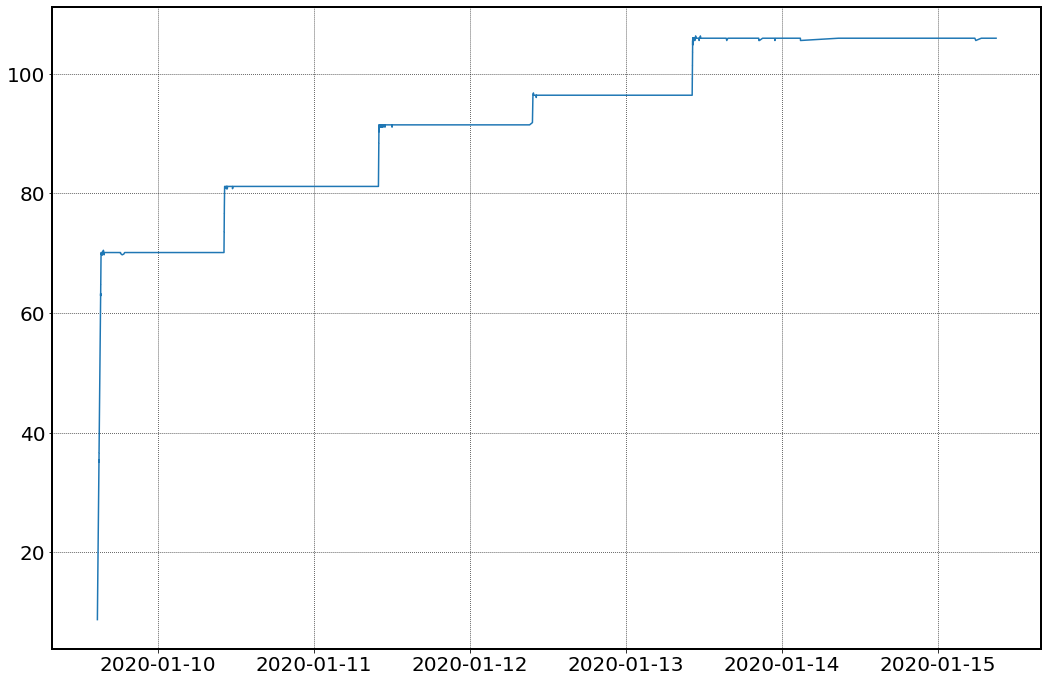

In [21]:
plt.plot(new_AE_data.Sig_diff_MPa,'-')

In [22]:
new_AE_data.to_csv(path_AE_data.split('.csv')[0]+'_AppendedMechanical_'+time_agg+'.csv')
print(path_AE_data.split('.csv')[0]+'_AppendedMechanical_'+time_agg+'.csv')

../00_Data/Dry_Basalt/dry_events_with_mechdata_AppendedMechanical_1min.csv


In [23]:
del new_AE_data

## Plotting/Analysis of the data with AE rate etc 

In [24]:
try  :
    os.mkdir(path_to_save_out_time_series+name_exp)
except :
    print(f' {path_to_save_out_time_series+name_exp} Exists')
    
try  :
    os.mkdir(path_to_save_out_time_series+name_exp+'/'+time_agg)
except :
    print(f"{path_to_save_out_time_series+name_exp+'/'+time_agg} Exists")

path_save_file = path_to_save_out_time_series+name_exp+'/'+time_agg

 /home/tmittal/Causality/Basalt_Data/dataforcausalitytests_Dry_Basalt Exists
/home/tmittal/Causality/Basalt_Data/dataforcausalitytests_Dry_Basalt/1min Exists


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 'Temp', 't_def', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'Time_Since_Step_4', 'AE_rate_count', 'strain_rate', 'stress_rate',
       'AE_rate_count_rate', 'Sig_AE_rate', 'strain_rate_AE_rate',
       'strain_AE_rate', 'Sig_strain', 'Sig_strain_rate',
       'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt Exists
Index value for the stress steps:  [   1   35 1174 2602 4020 5495]
Time(hr) for the stress steps:  [4.12500000e-02 1.95911111e+01 4.33912500e+01 6.70245833e+01
 9.16079167e+01]


60

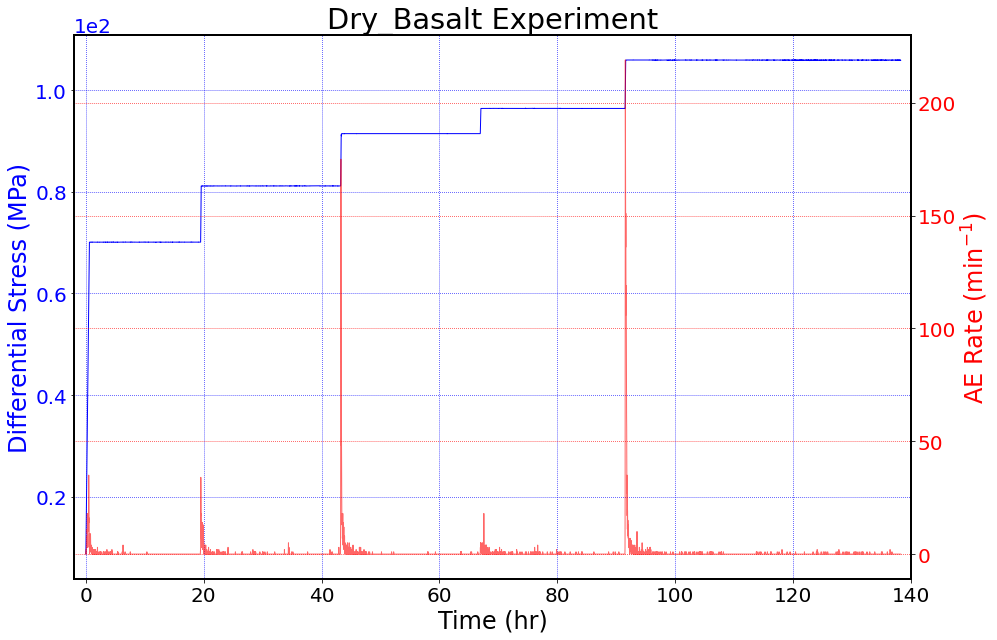

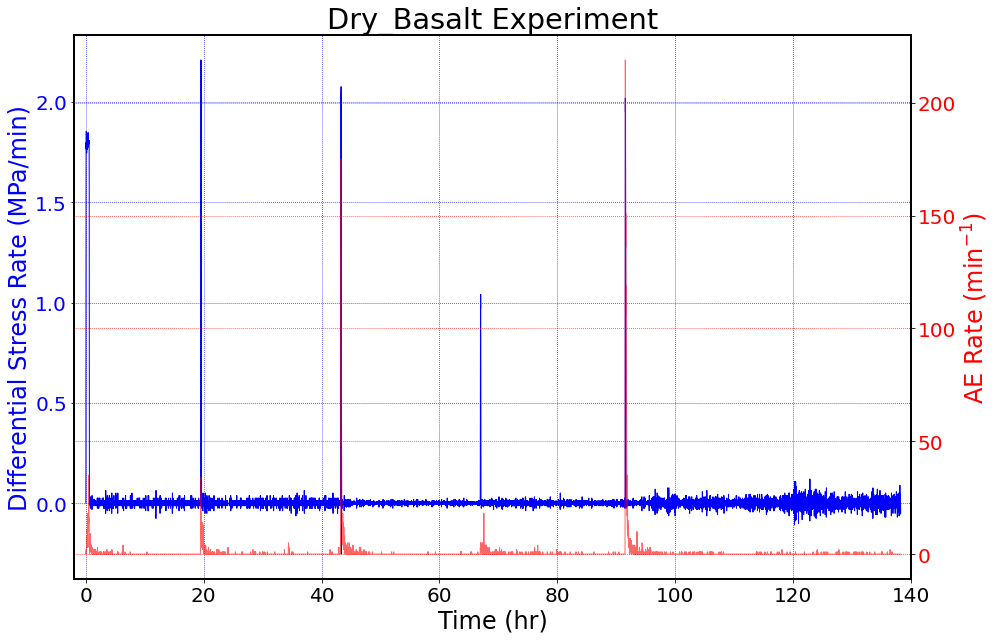

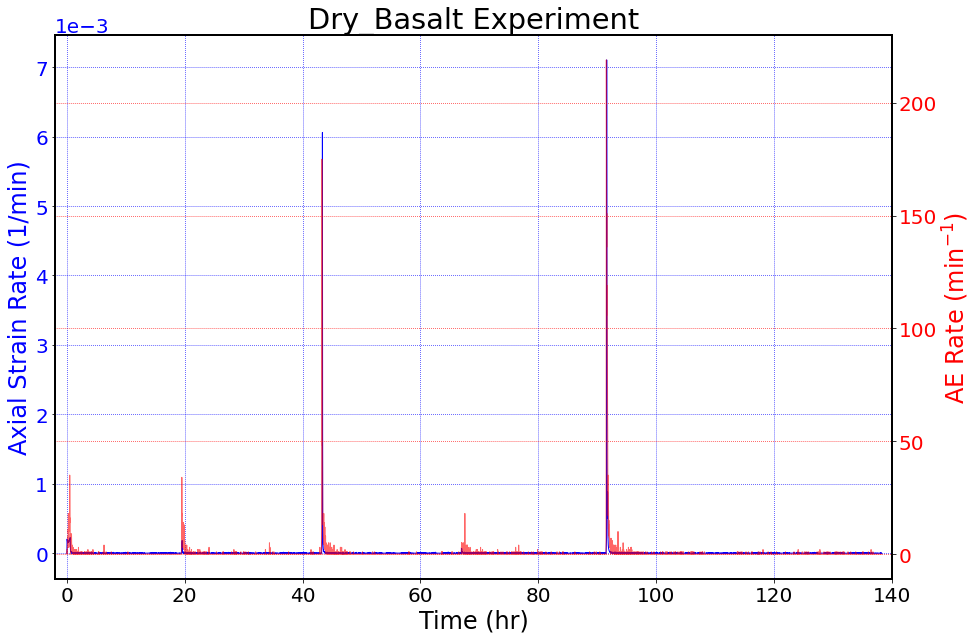

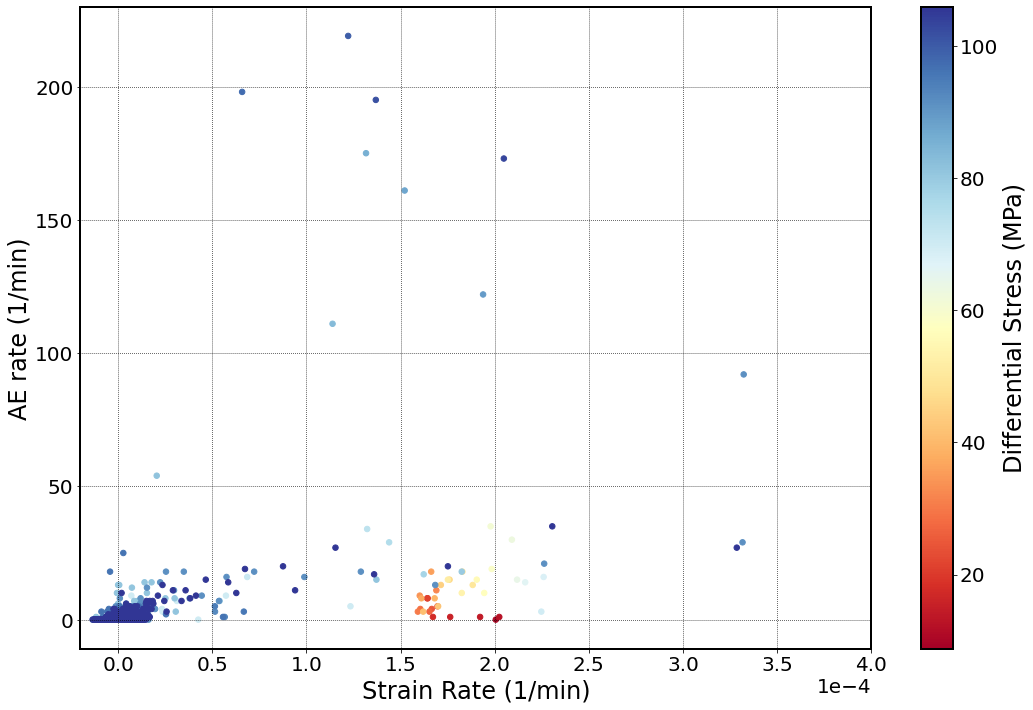

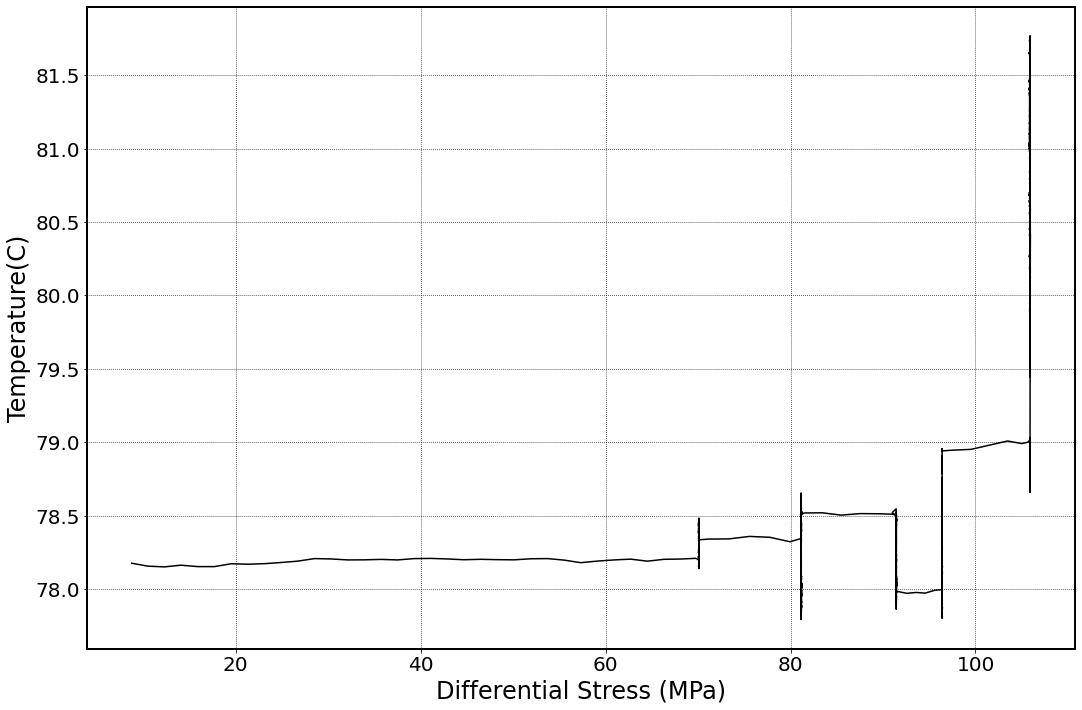

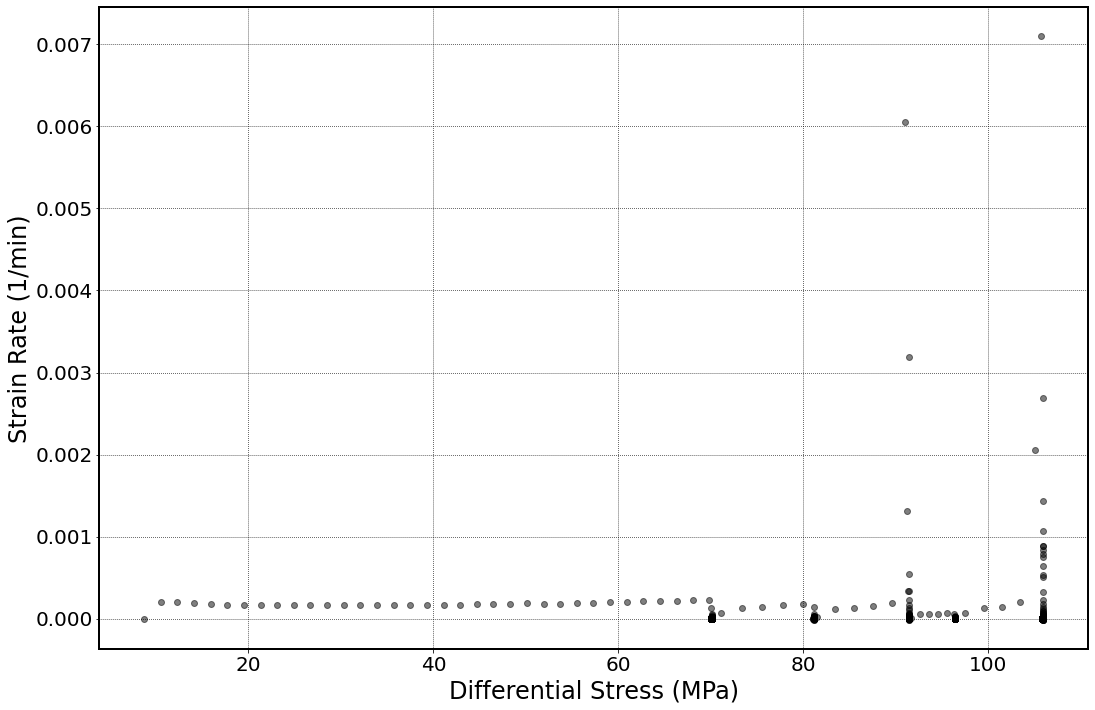

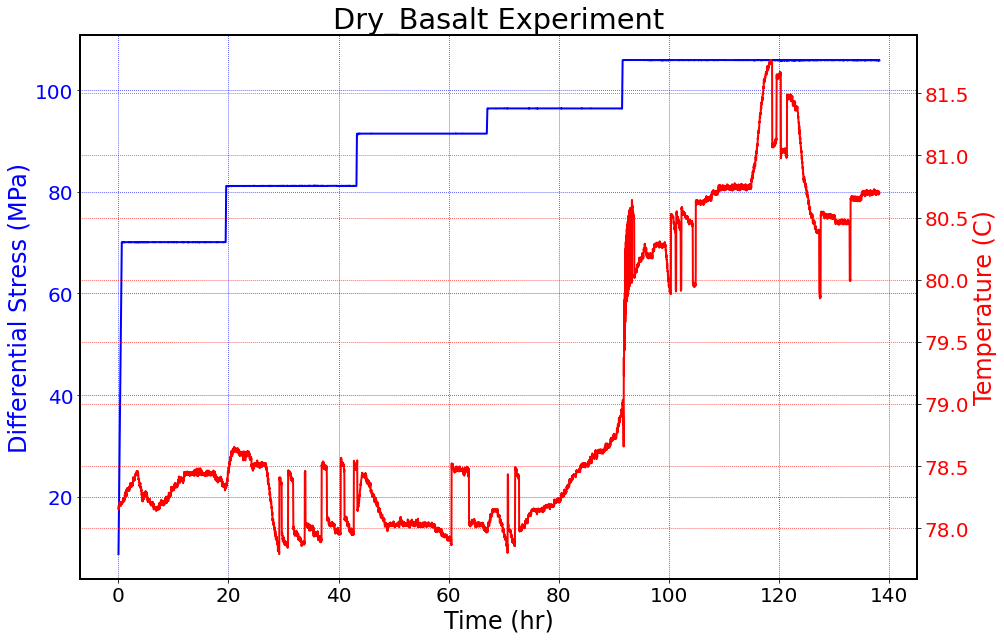

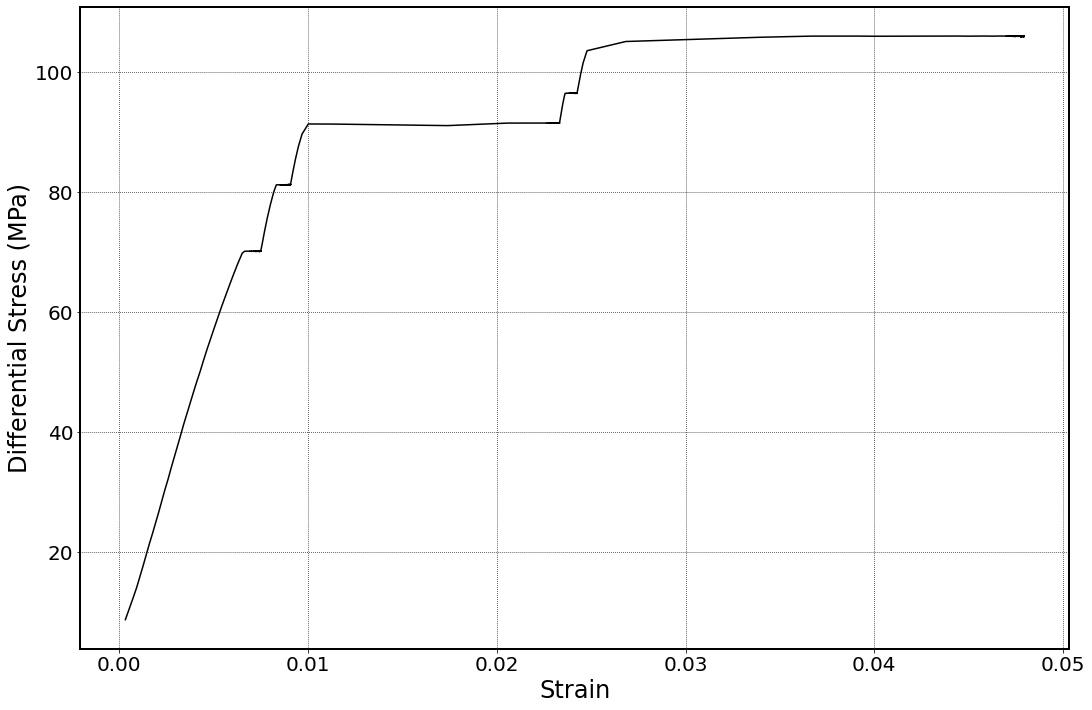

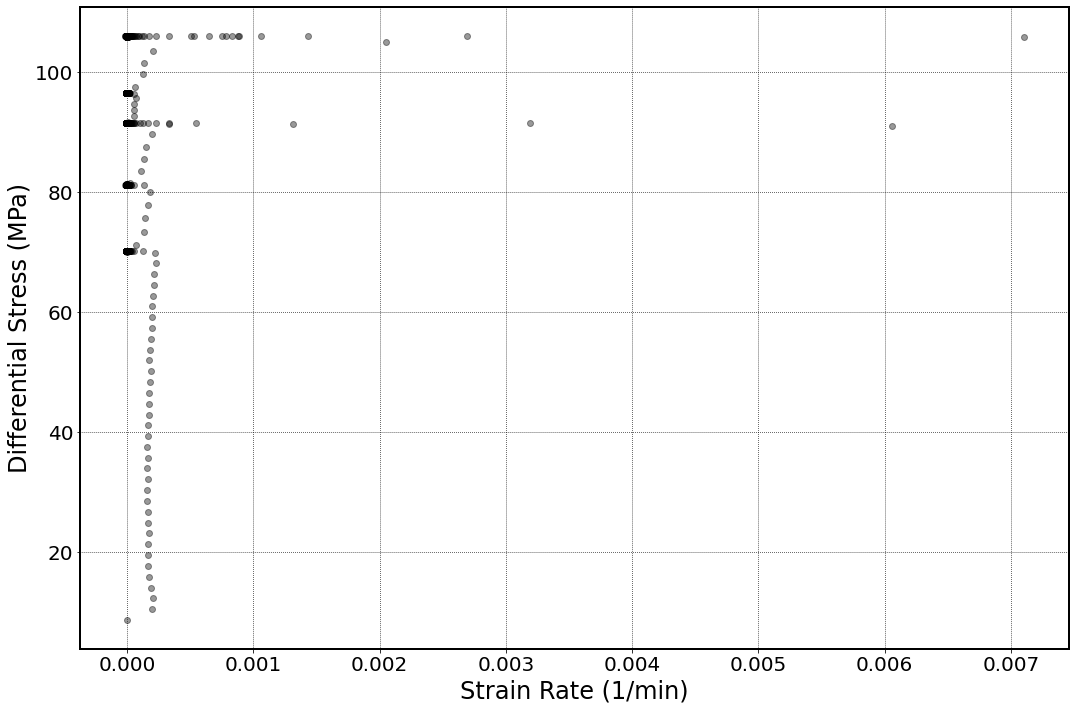

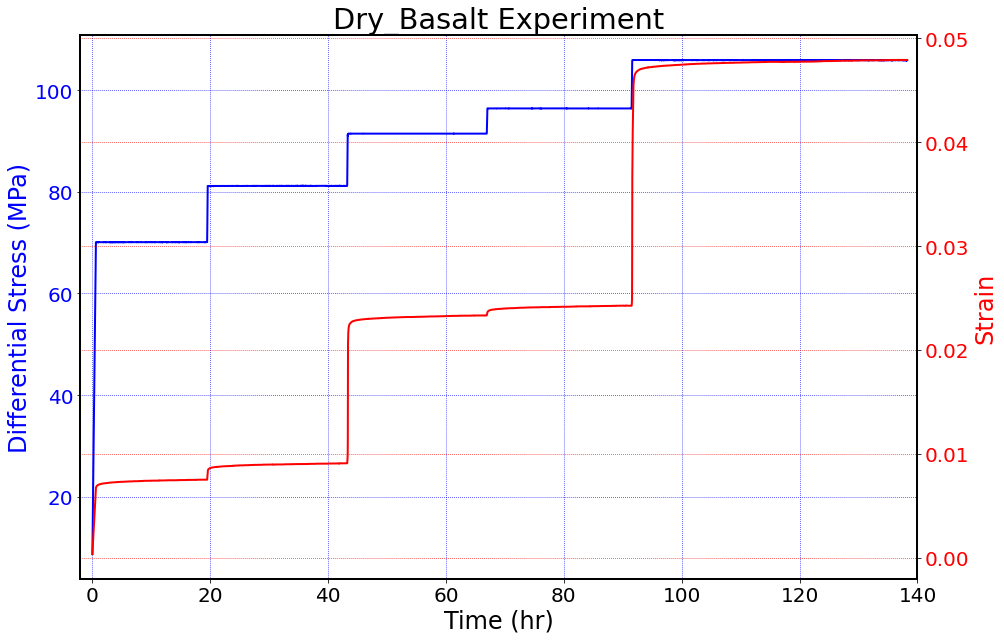

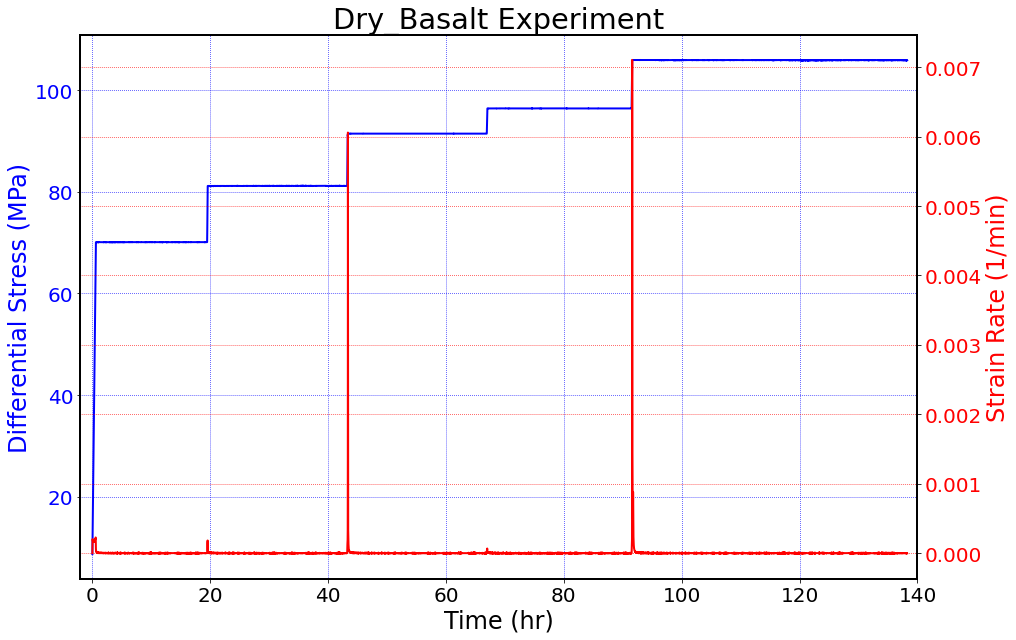

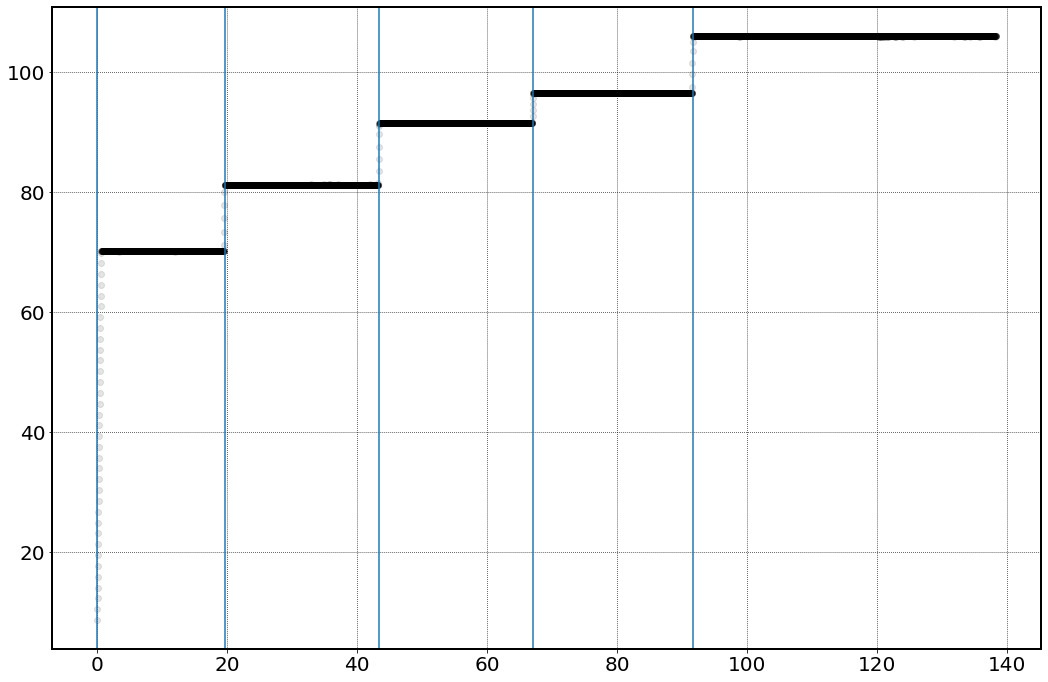

In [25]:
#%matplotlib qt
time_window = 60
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 'Temp', 't_def', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'Time_Since_Step_4', 'AE_rate_count', 'strain_rate', 'stress_rate',
       'AE_rate_count_rate', 'Sig_AE_rate', 'strain_rate_AE_rate',
       'strain_AE_rate', 'Sig_strain', 'Sig_strain_rate',
       'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt Exists
Index value for the stress steps:  [   1   17  587 1300 2010 2748]
Time(hr) for the stress steps:  [6.62500000e-02 1.95994444e+01 4.33662500e+01 6.70329167e+01
 9.16329167e+01]


53332

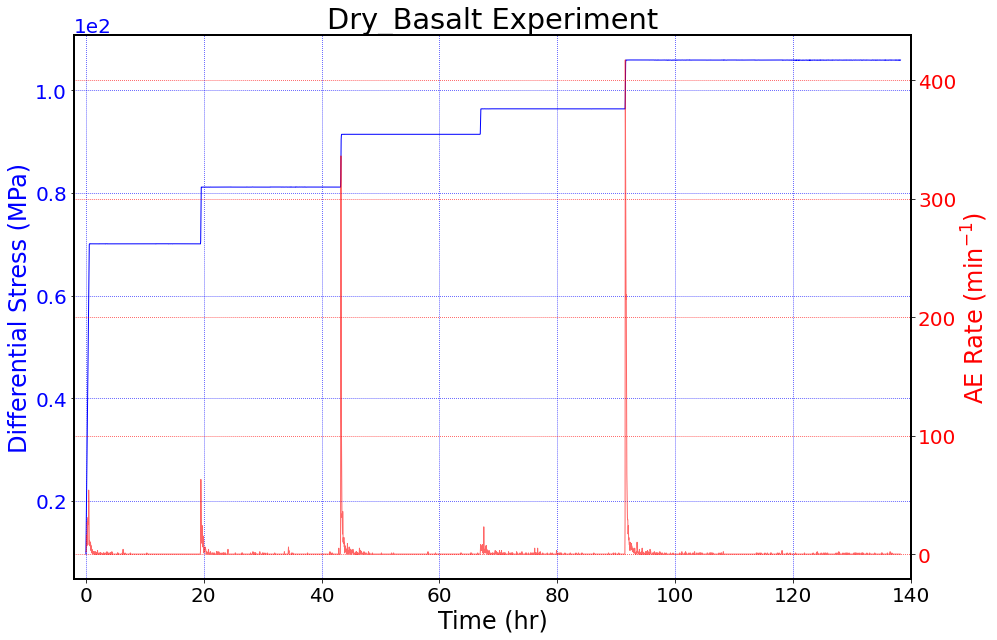

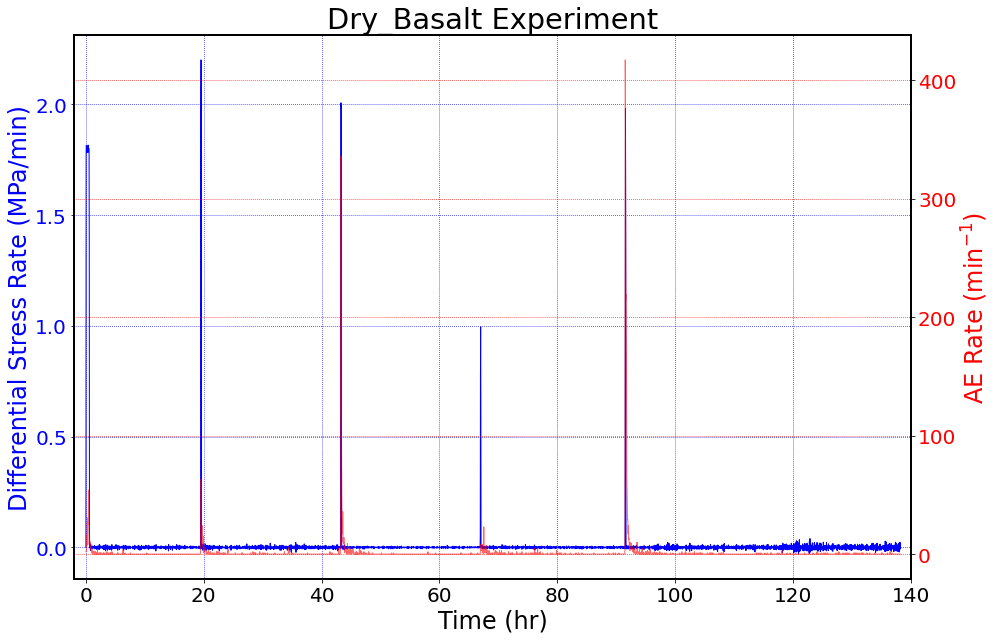

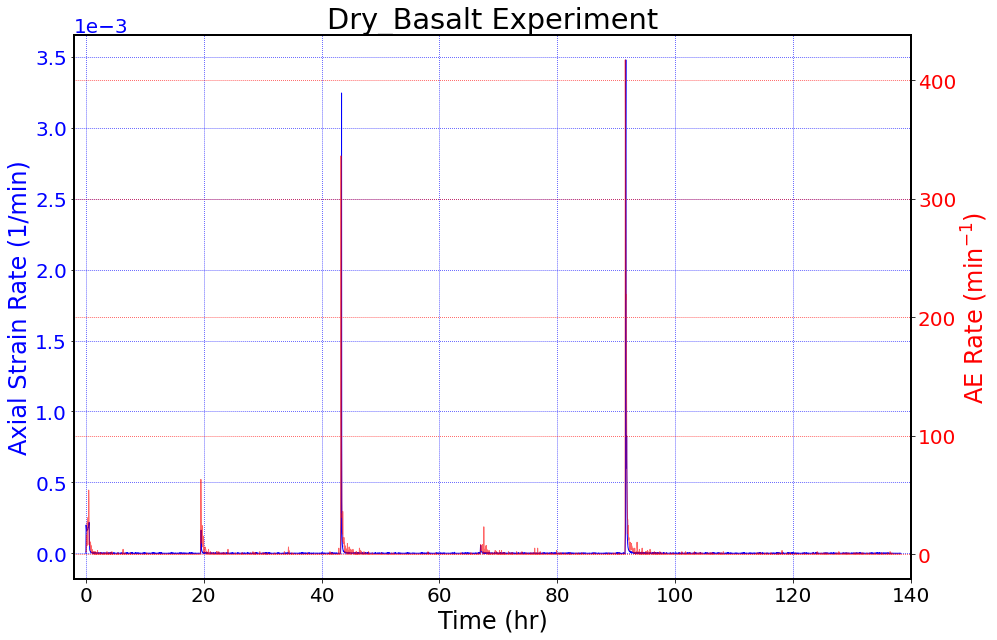

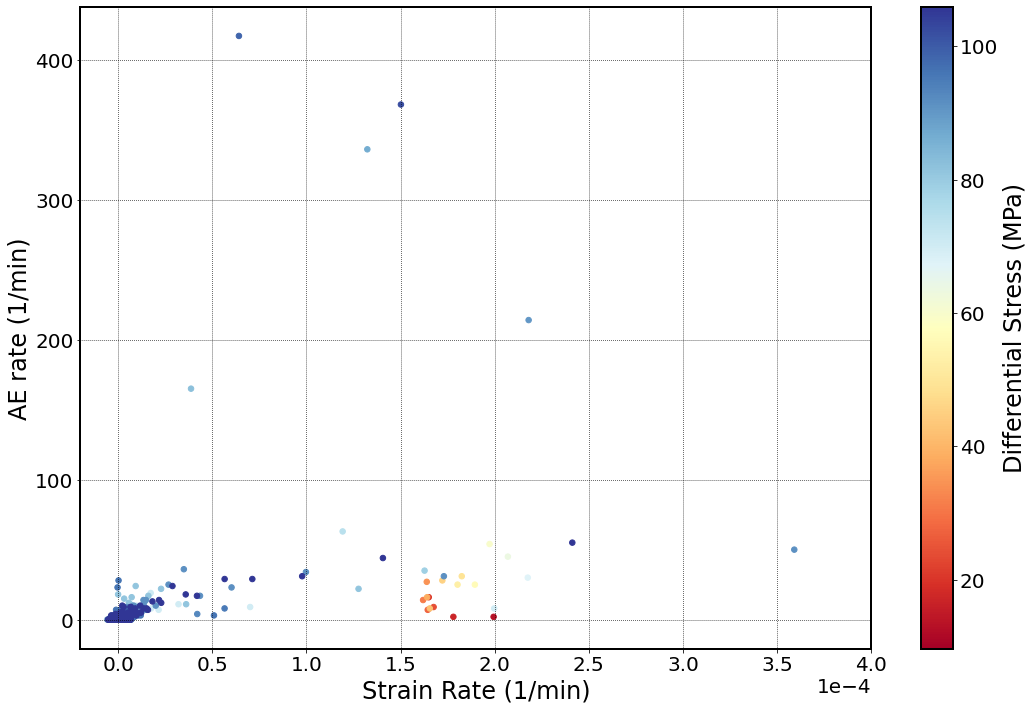

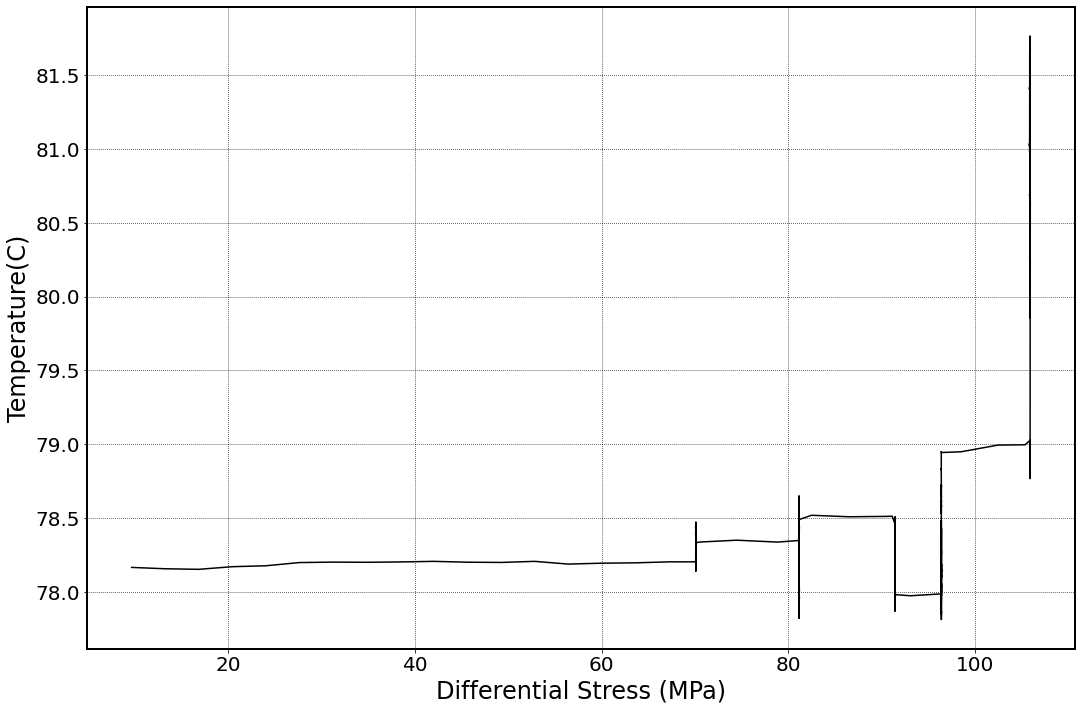

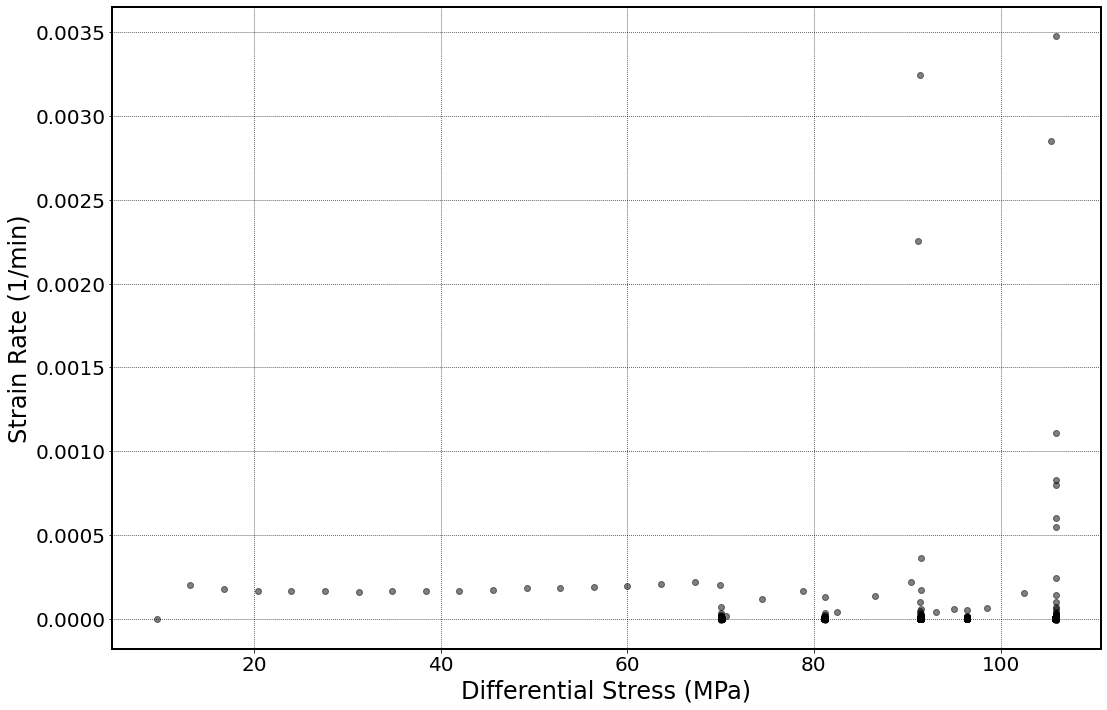

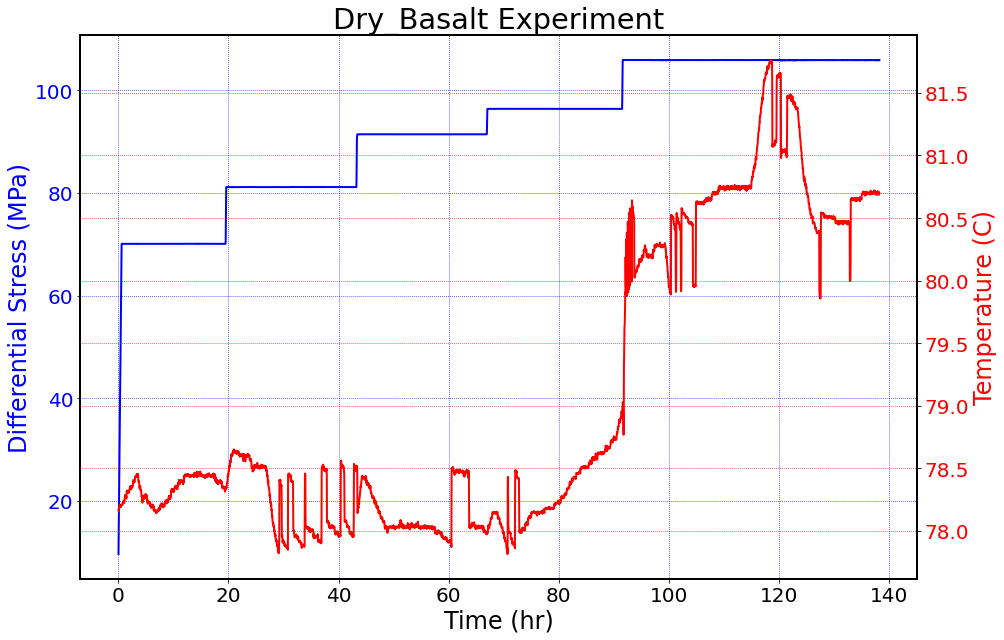

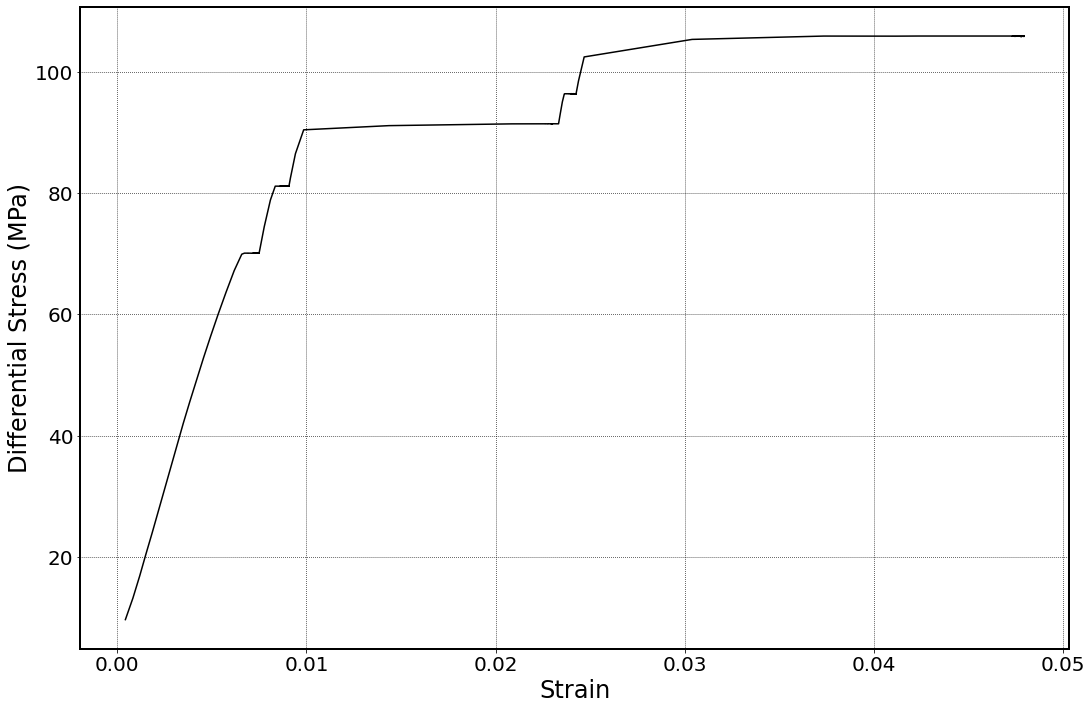

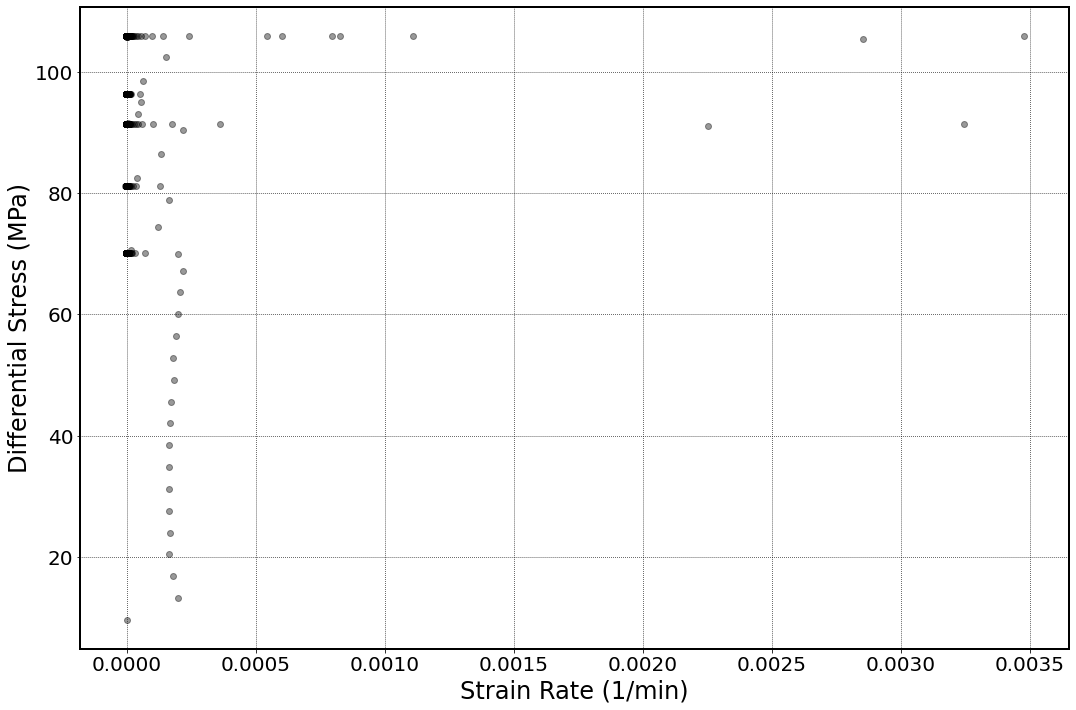

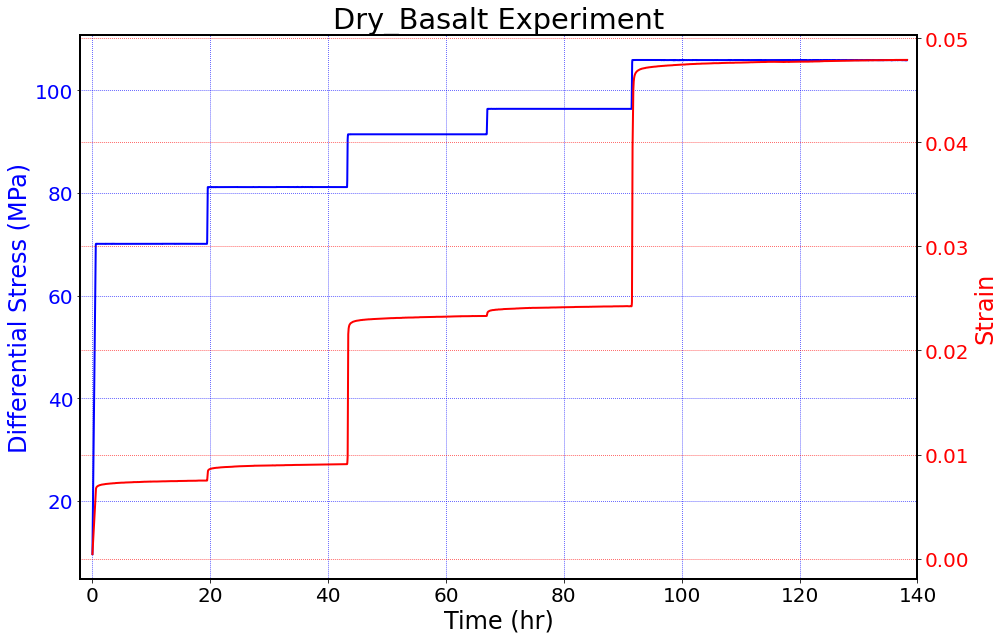

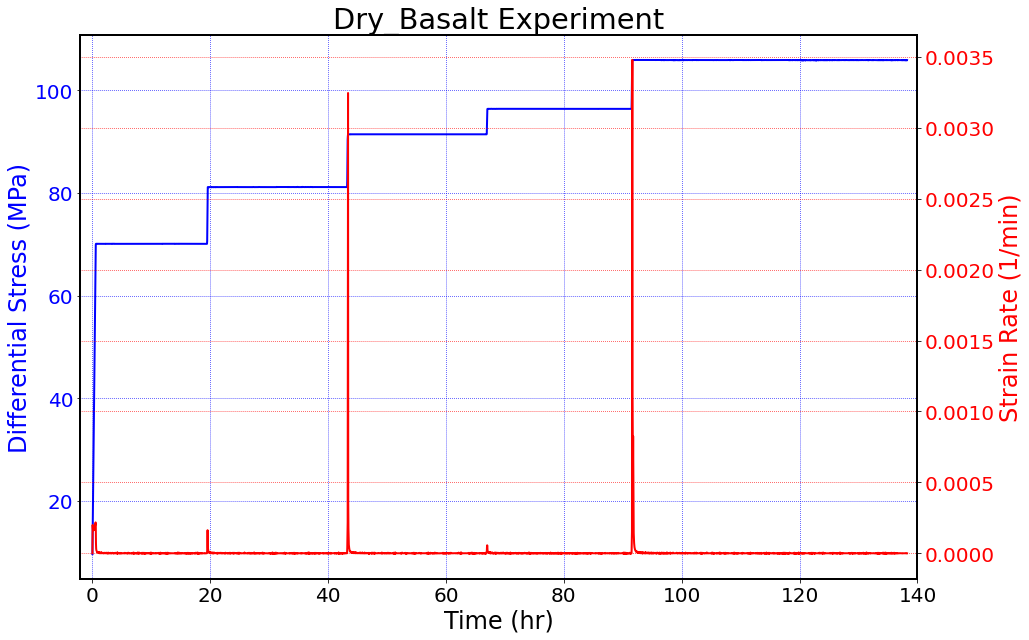

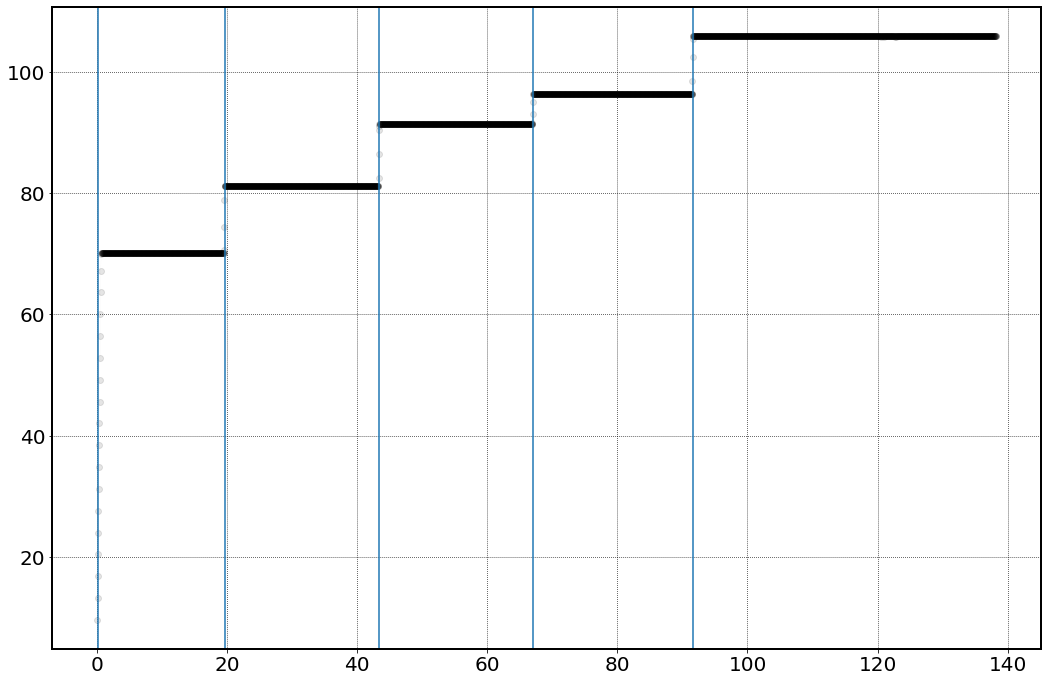

In [26]:
time_window = 120
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 'Temp', 't_def', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'Time_Since_Step_4', 'AE_rate_count', 'strain_rate', 'stress_rate',
       'AE_rate_count_rate', 'Sig_AE_rate', 'strain_rate_AE_rate',
       'strain_AE_rate', 'Sig_strain', 'Sig_strain_rate',
       'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt Exists
Index value for the stress steps:  [   1   12  392  867 1340 1832]
Time(hr) for the stress steps:  [7.45833333e-02 1.96244444e+01 4.33745833e+01 6.70245833e+01
 9.16245833e+01]


53060

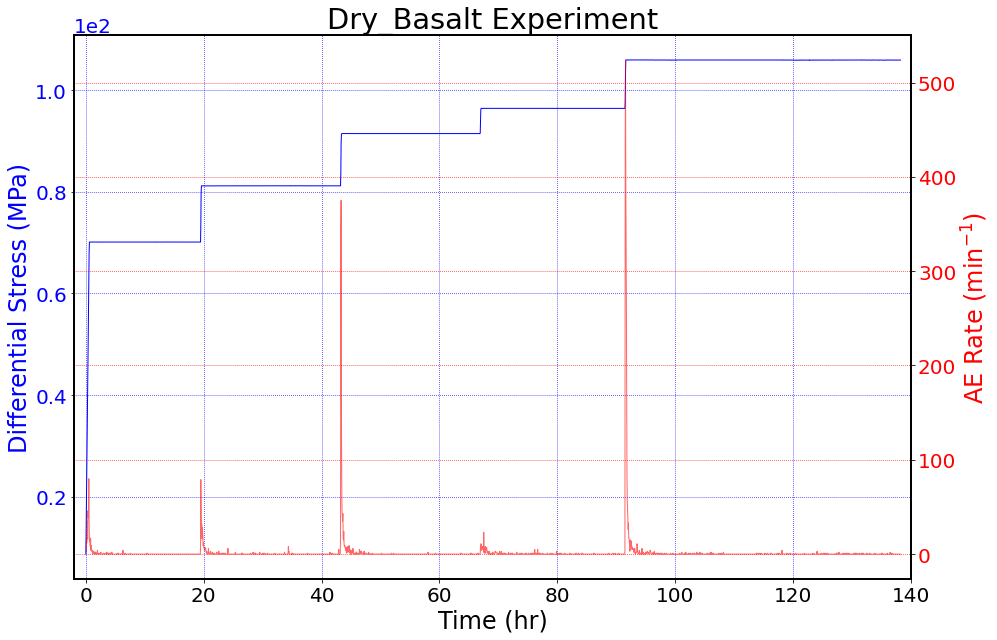

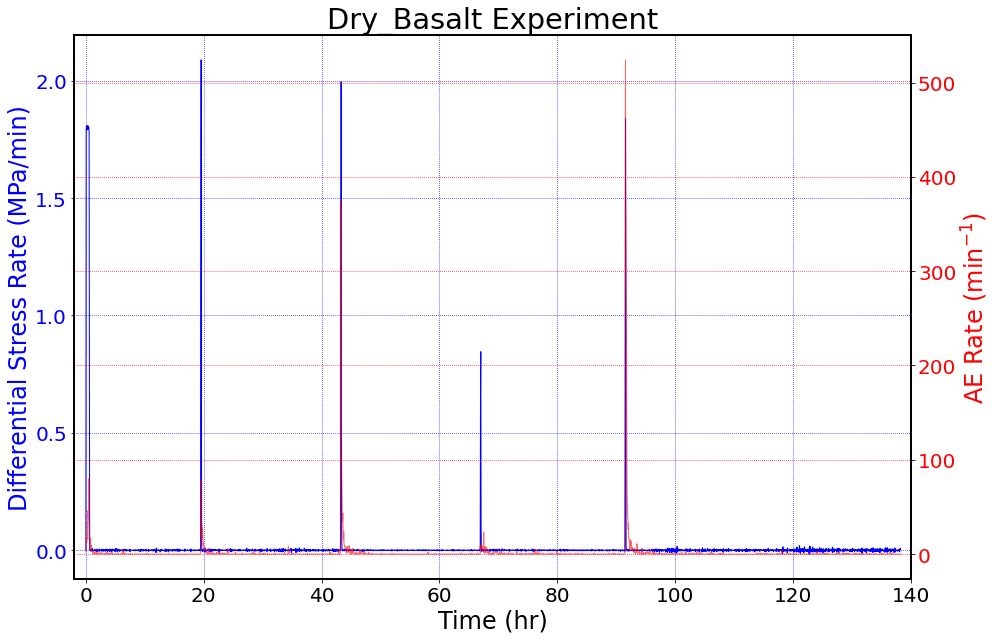

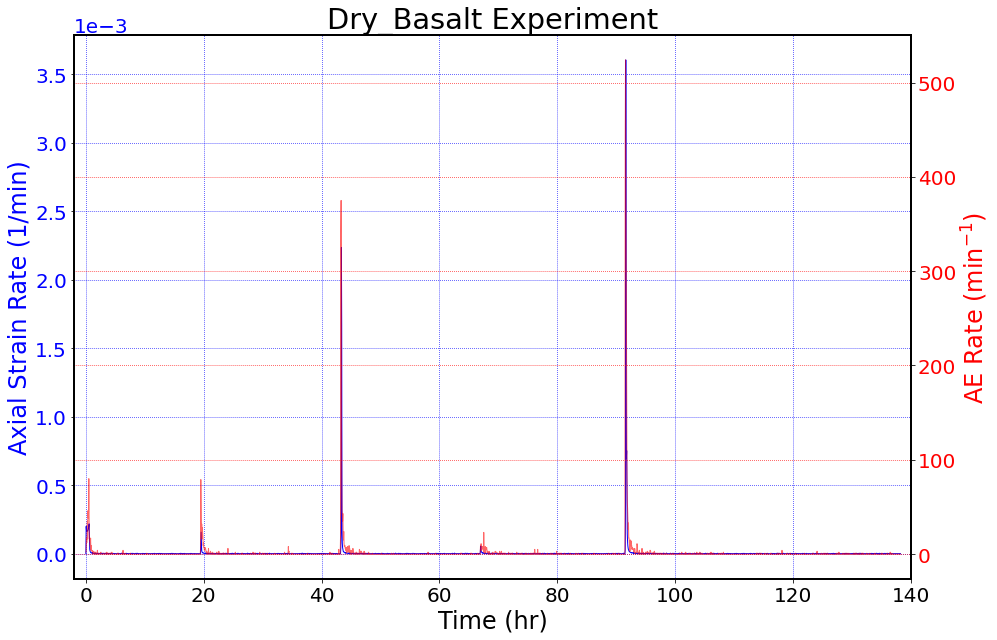

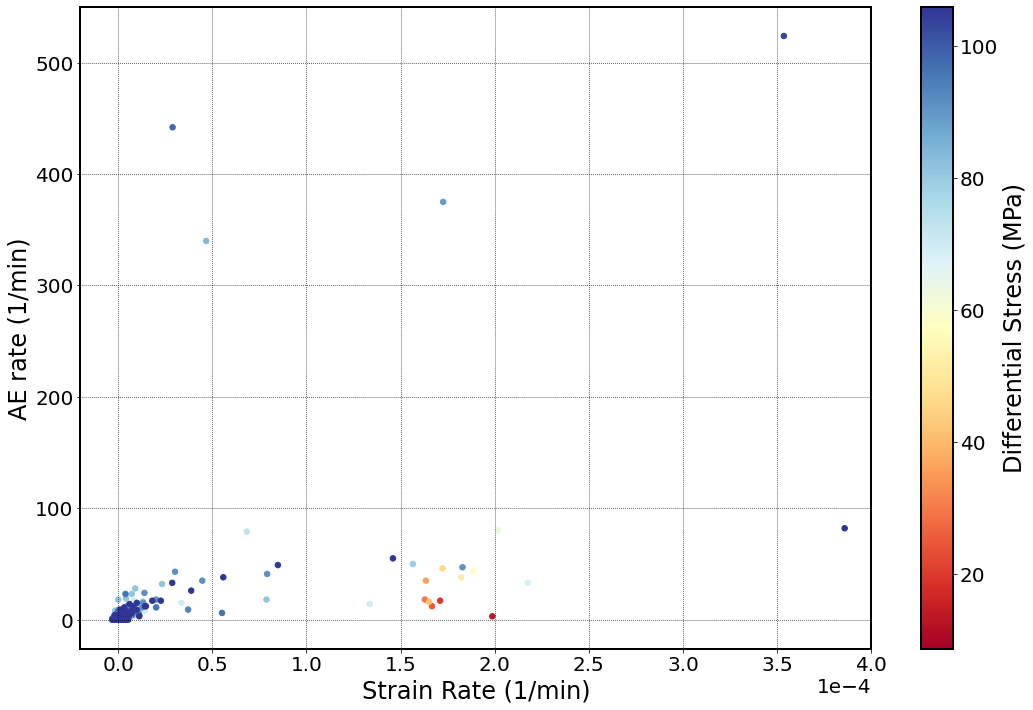

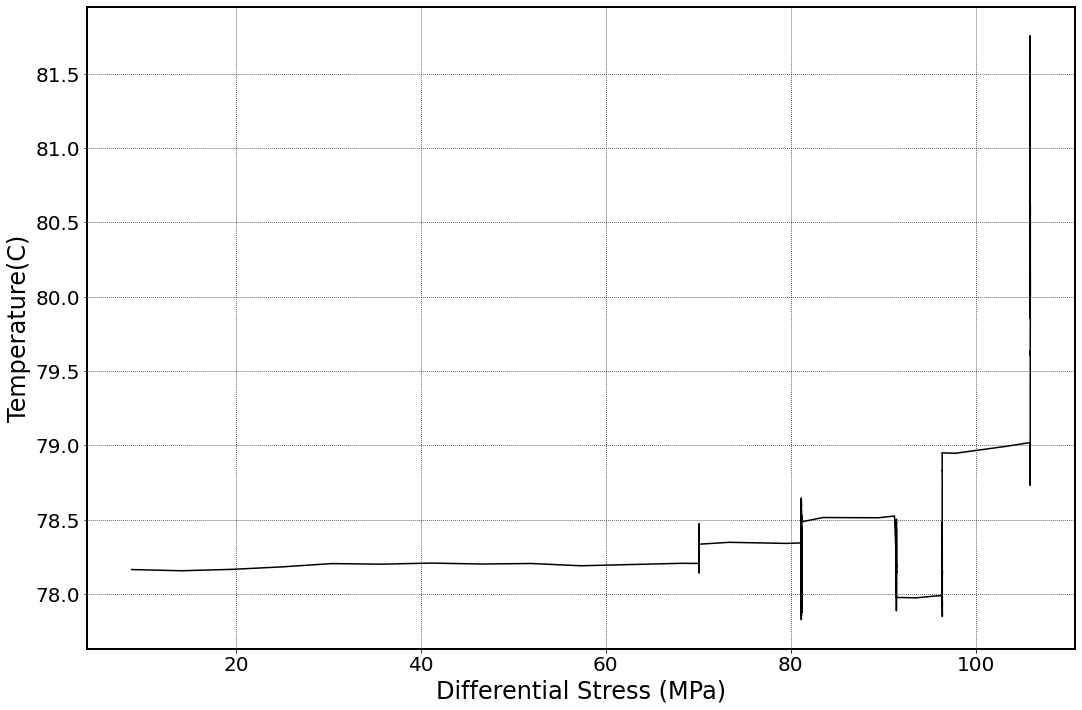

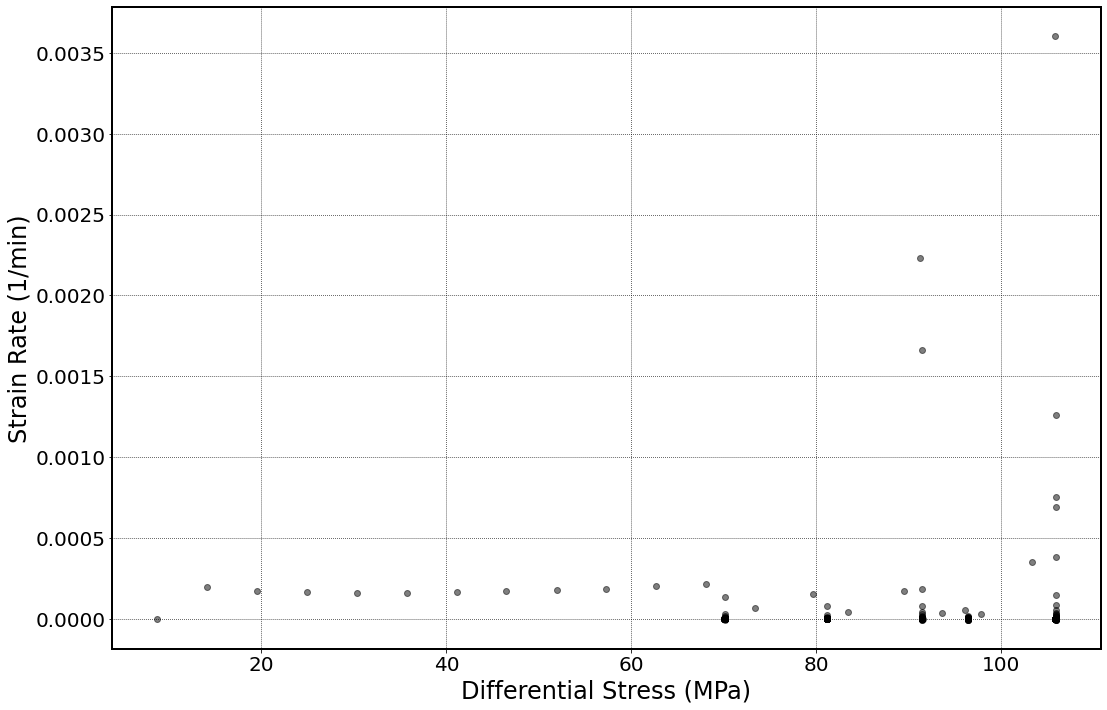

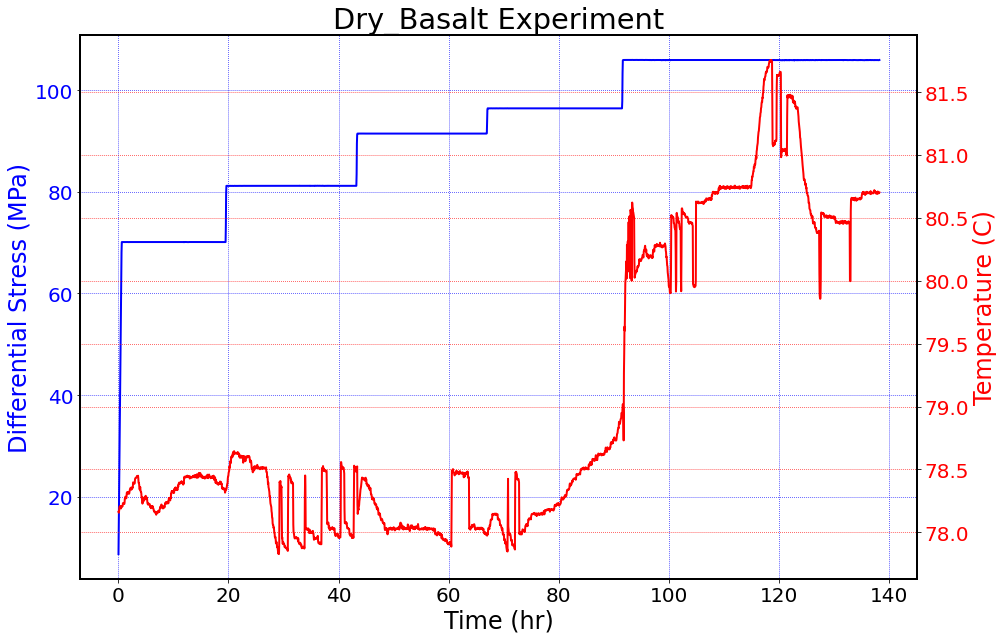

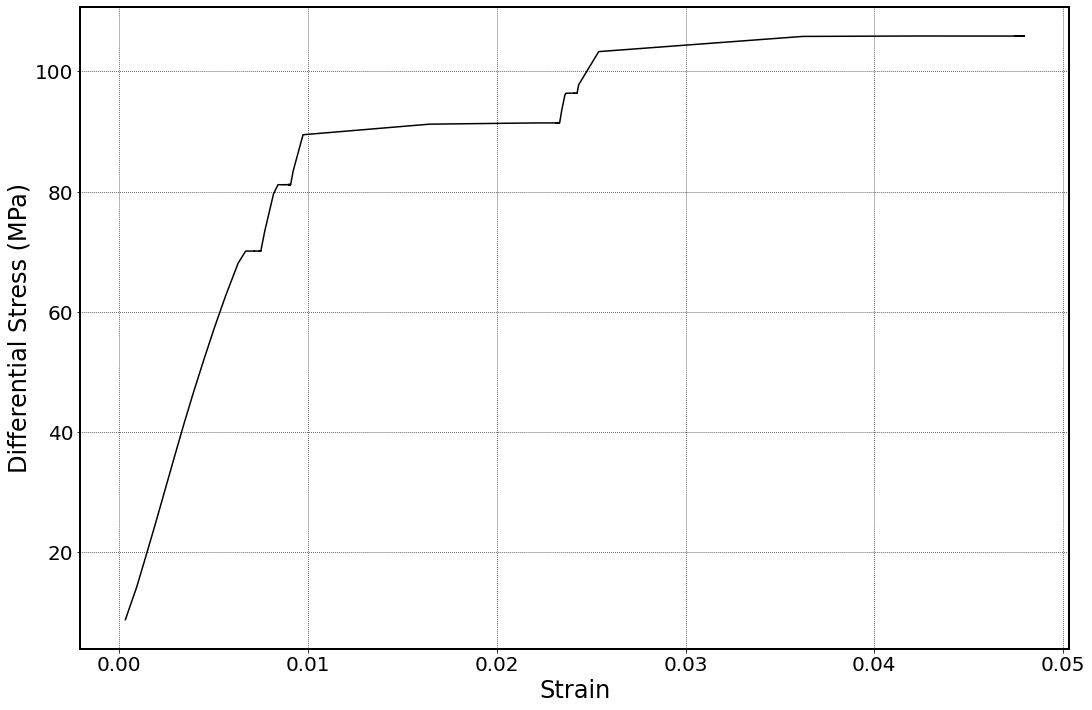

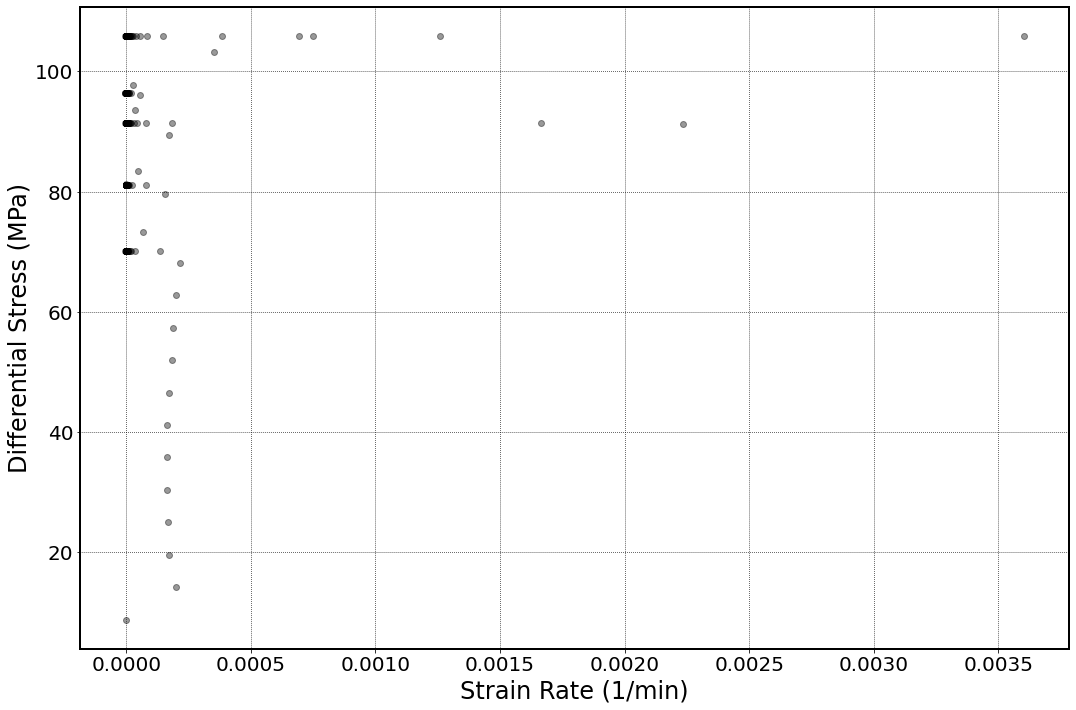

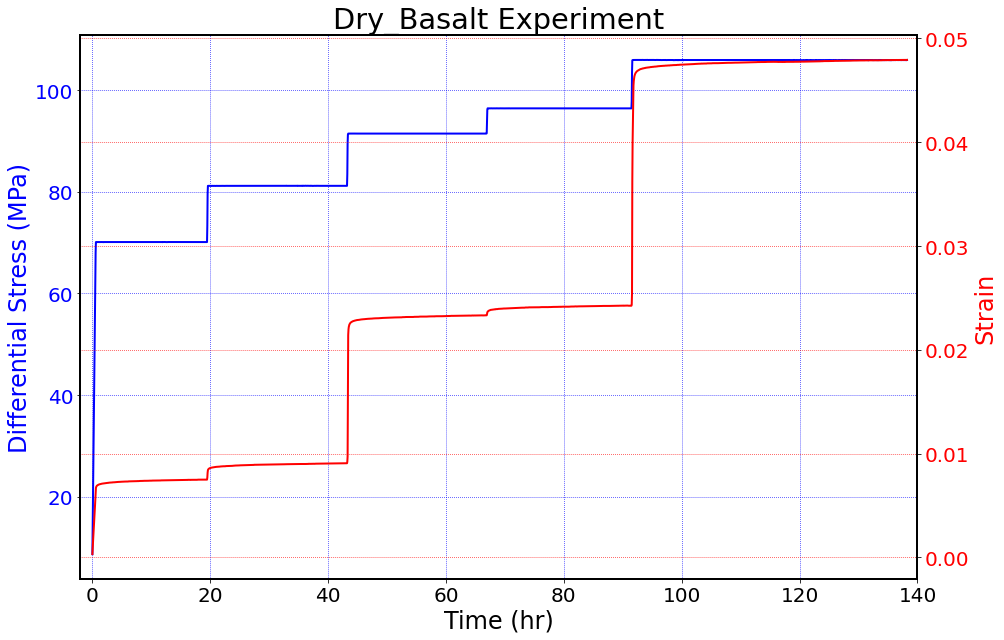

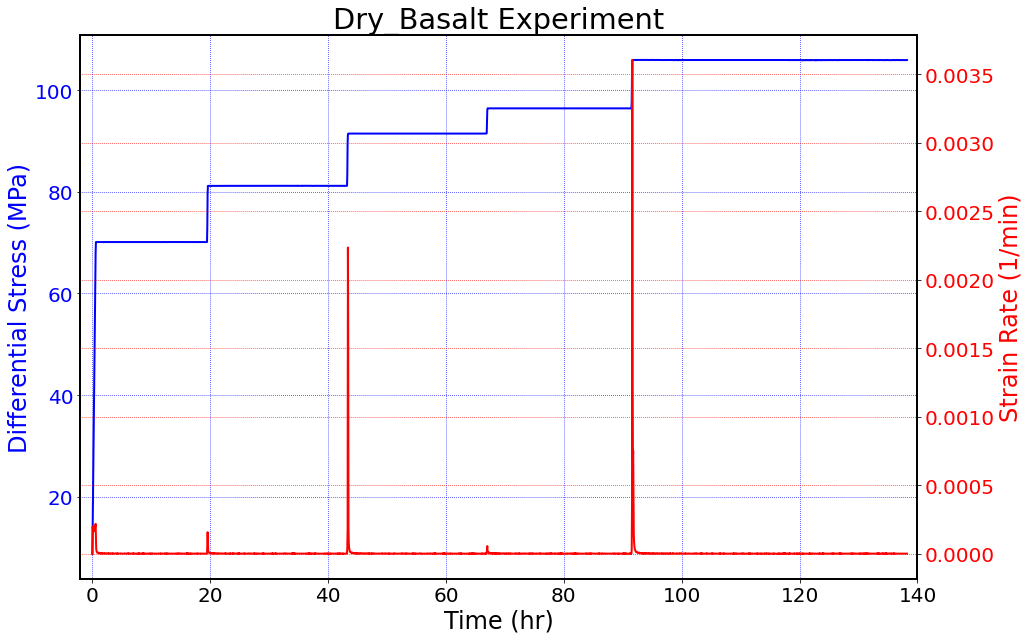

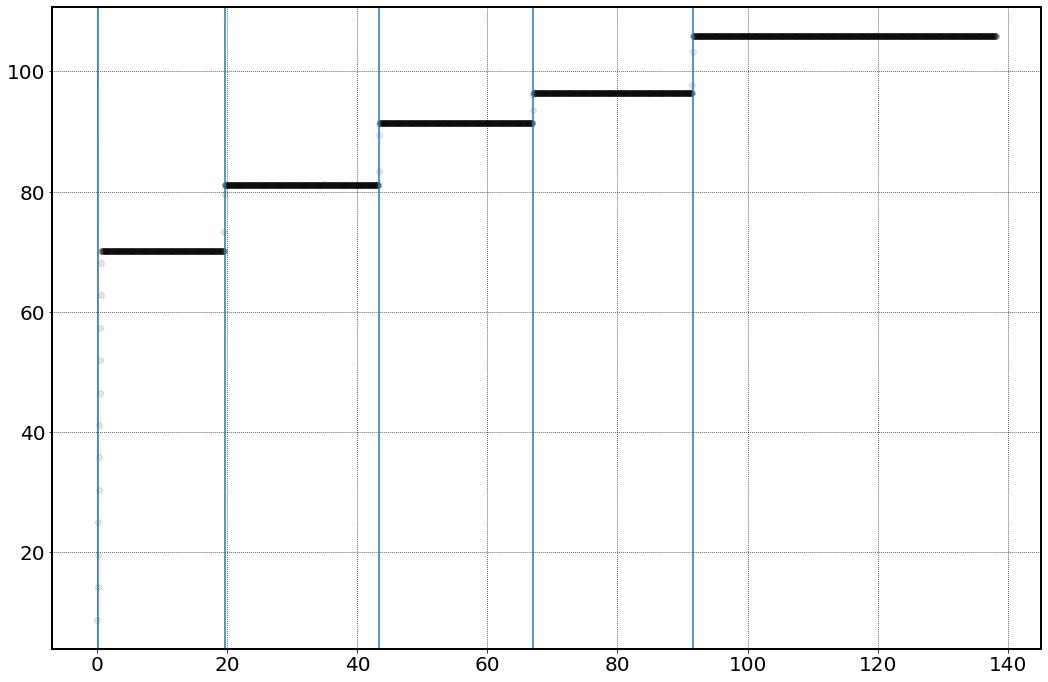

In [27]:
time_window = 180
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 'Temp', 't_def', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'Time_Since_Step_4', 'AE_rate_count', 'strain_rate', 'stress_rate',
       'AE_rate_count_rate', 'Sig_AE_rate', 'strain_rate_AE_rate',
       'strain_AE_rate', 'Sig_strain', 'Sig_strain_rate',
       'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt Exists
Index value for the stress steps:  [   1    7  235  520  804 1099]
Time(hr) for the stress steps:  [ 0.14125    19.64111111 43.39125    67.05791667 91.64125   ]


53911

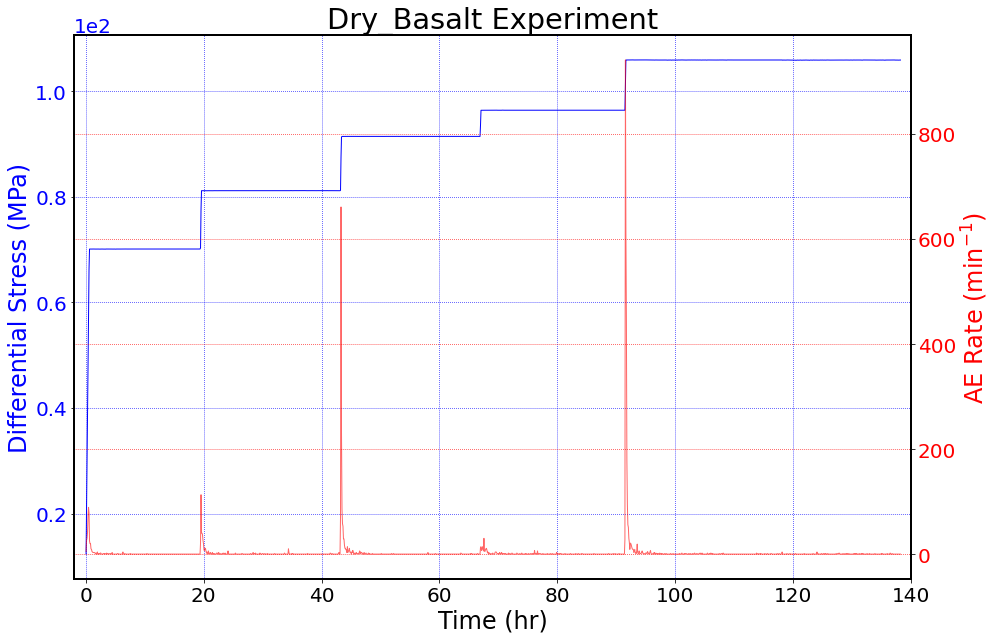

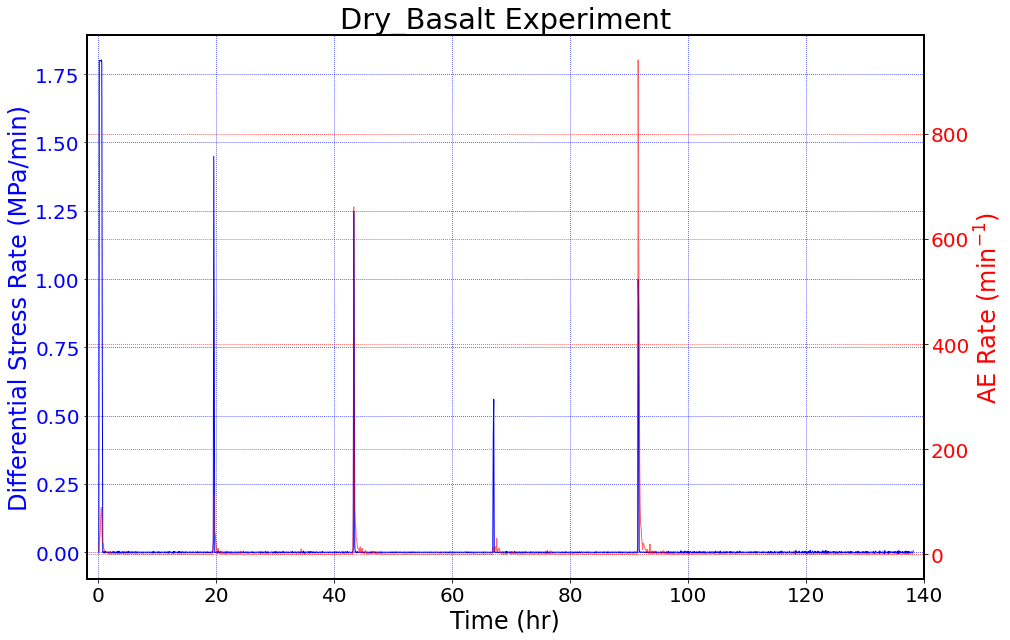

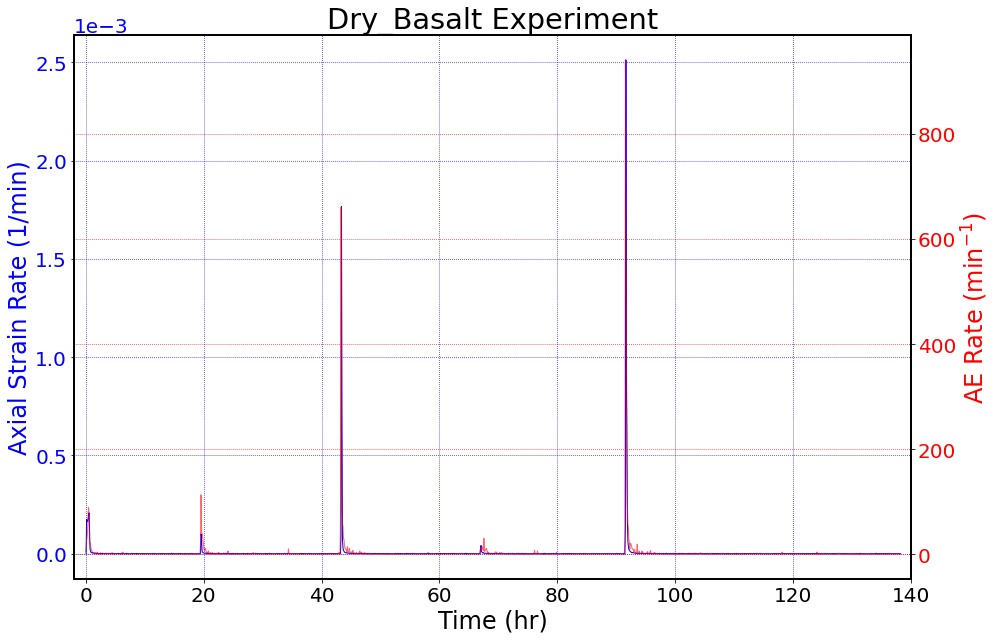

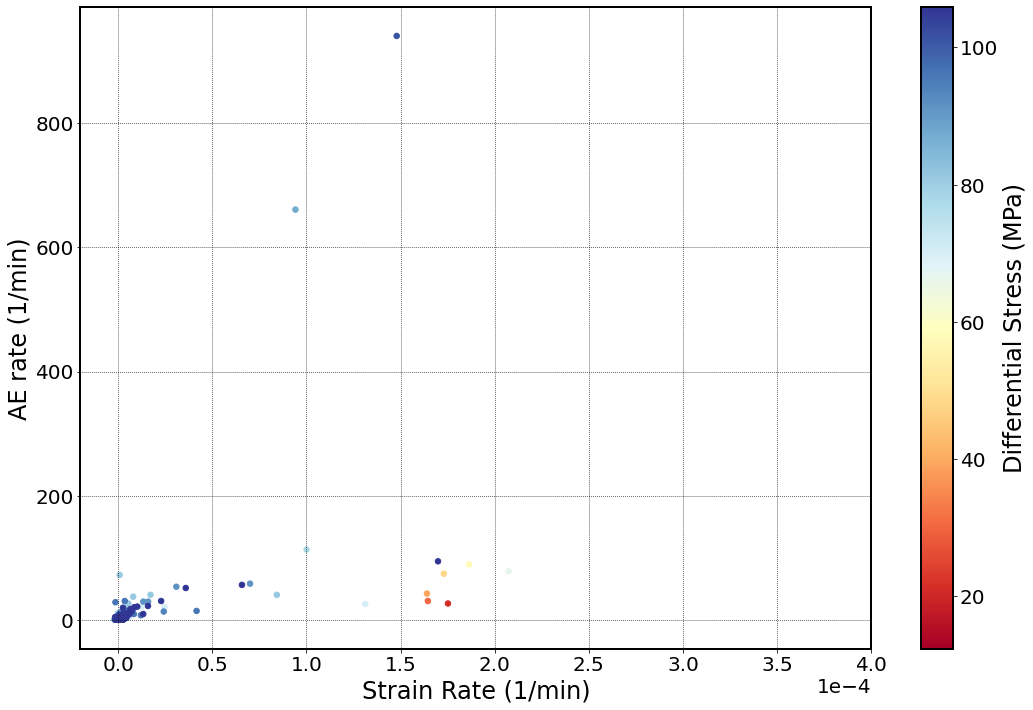

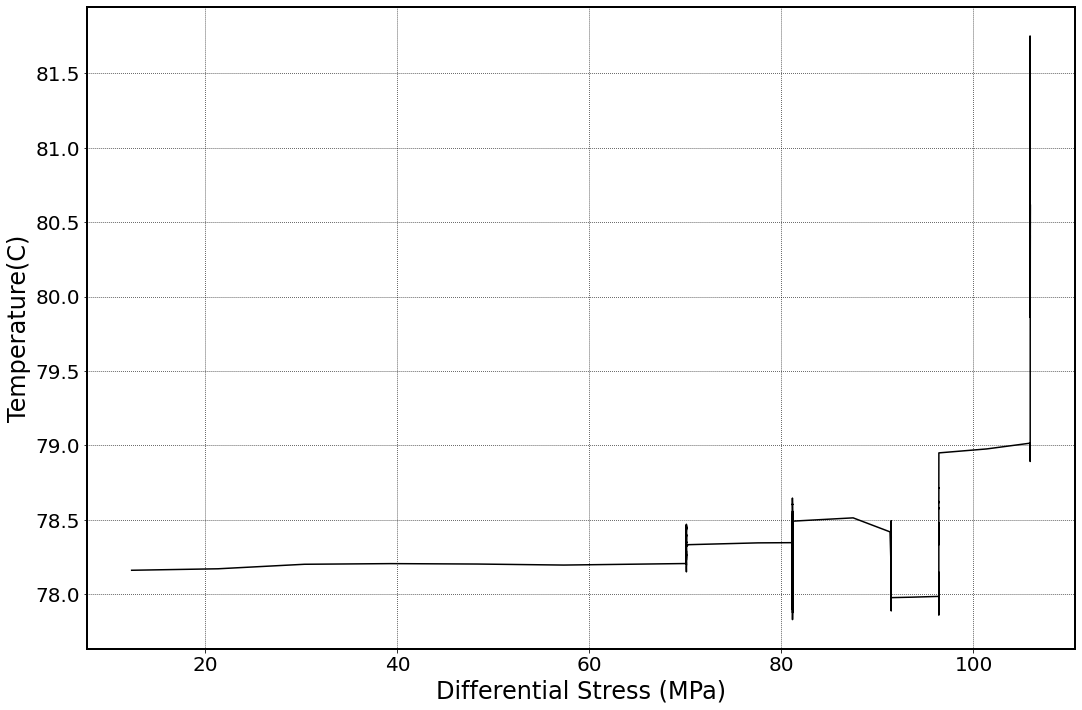

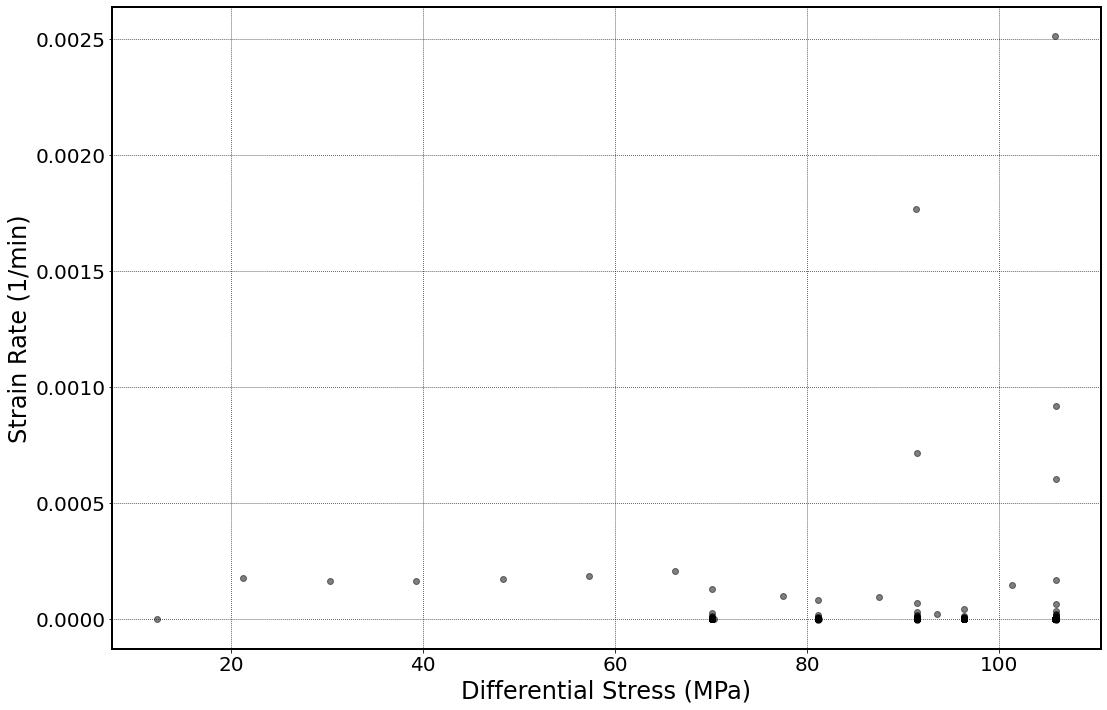

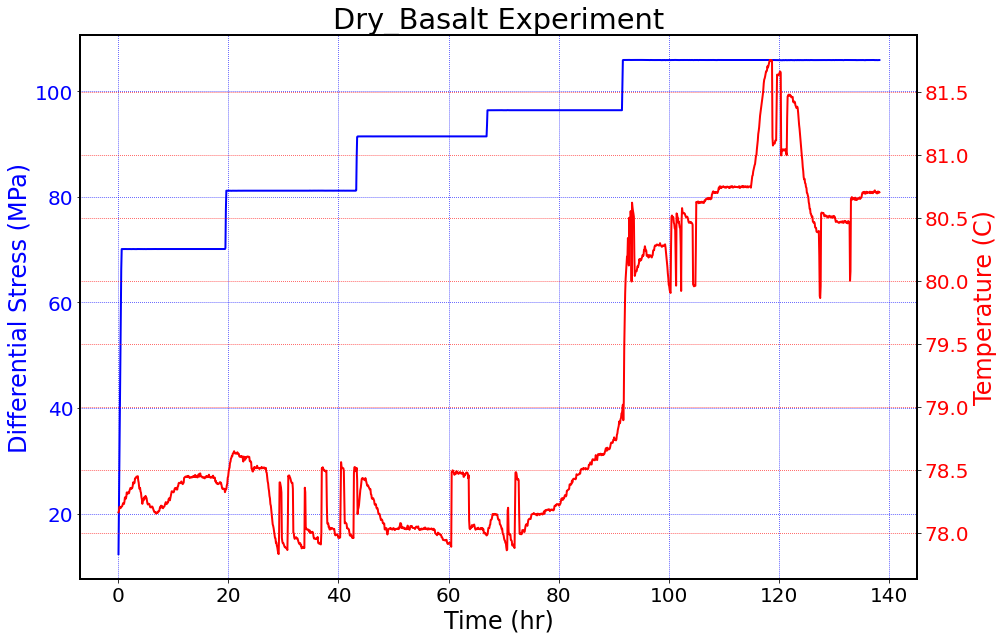

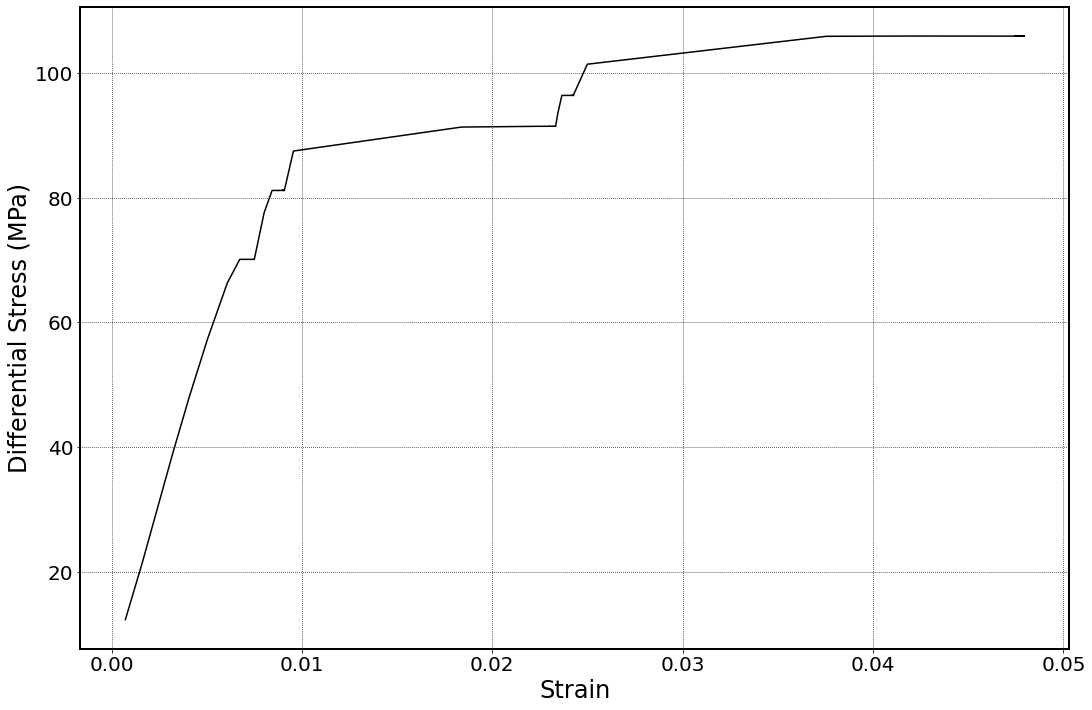

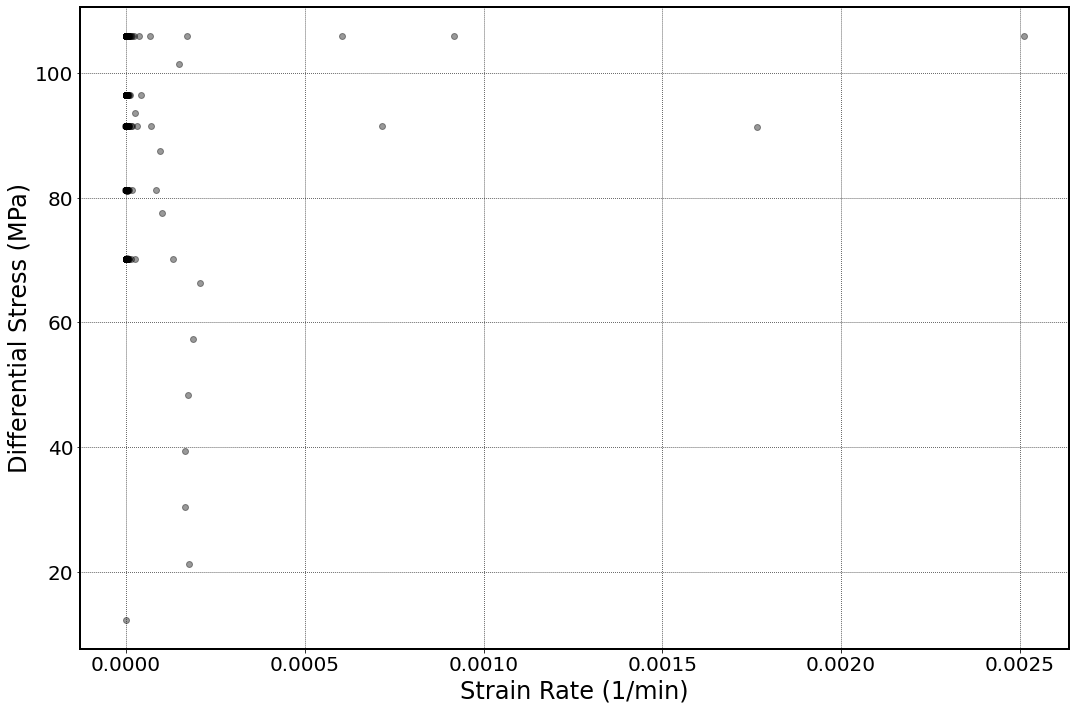

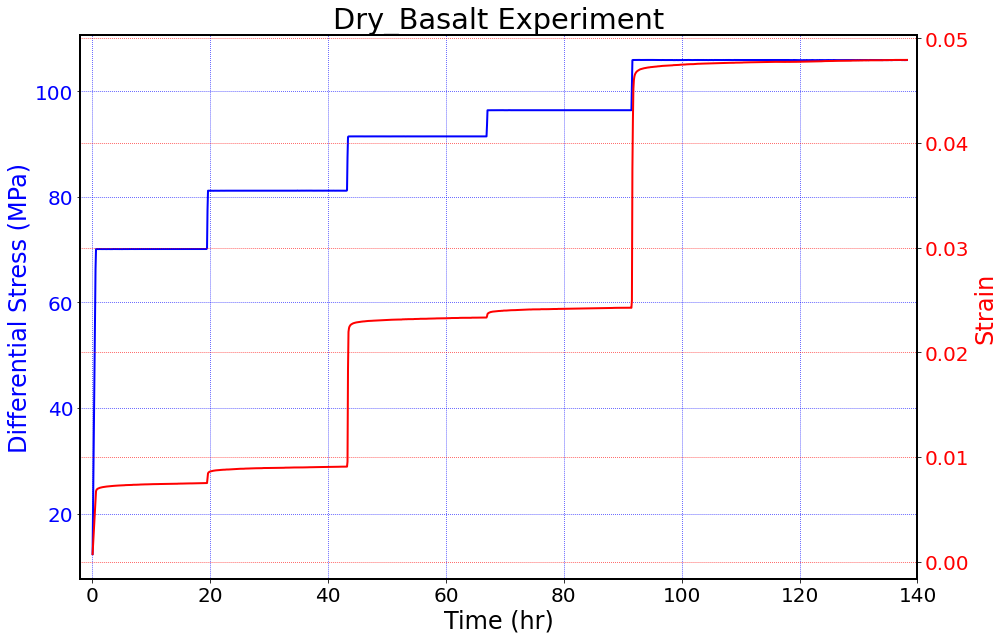

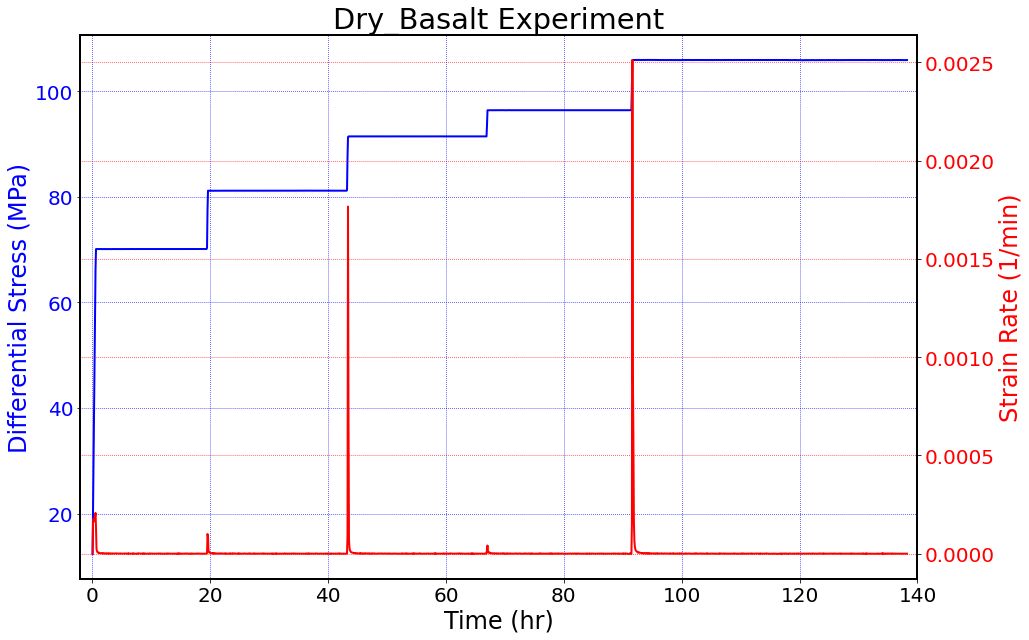

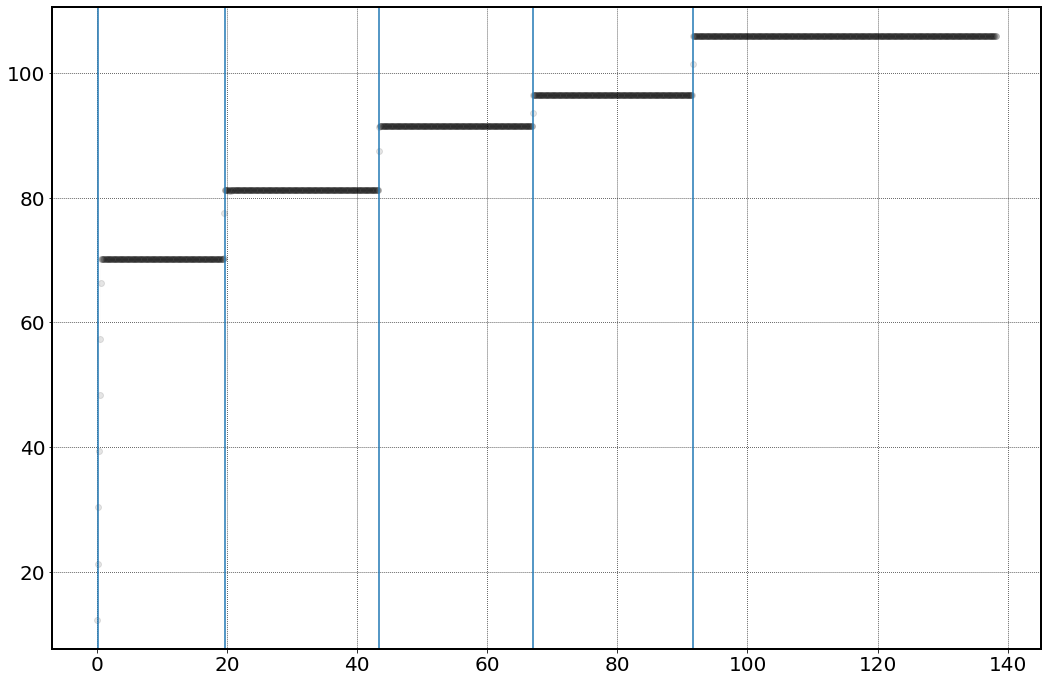

In [28]:
time_window = 300
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 'Strain_ax', 'Temp', 't_def', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'Time_Since_Step_3',
       'Time_Since_Step_4', 'AE_rate_count', 'strain_rate', 'stress_rate',
       'AE_rate_count_rate', 'Sig_AE_rate', 'strain_rate_AE_rate',
       'strain_AE_rate', 'Sig_strain', 'Sig_strain_rate',
       'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt Exists
Index value for the stress steps:  [  1   3 117 260 402 549]
Time(hr) for the stress steps:  [ 0.26625    19.59944444 43.43291667 67.09958333 91.59958333]


52797

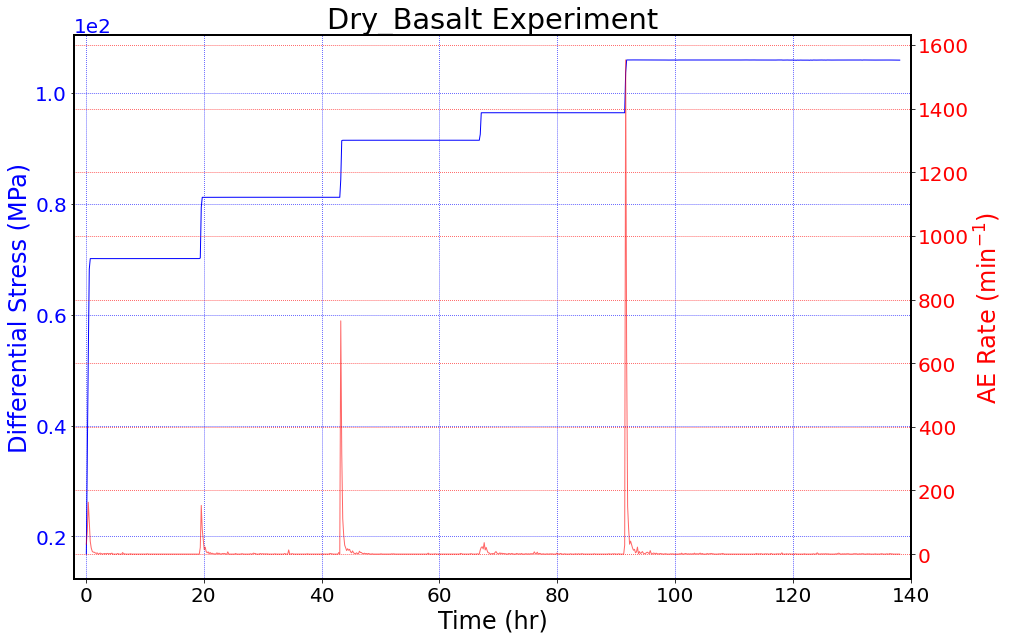

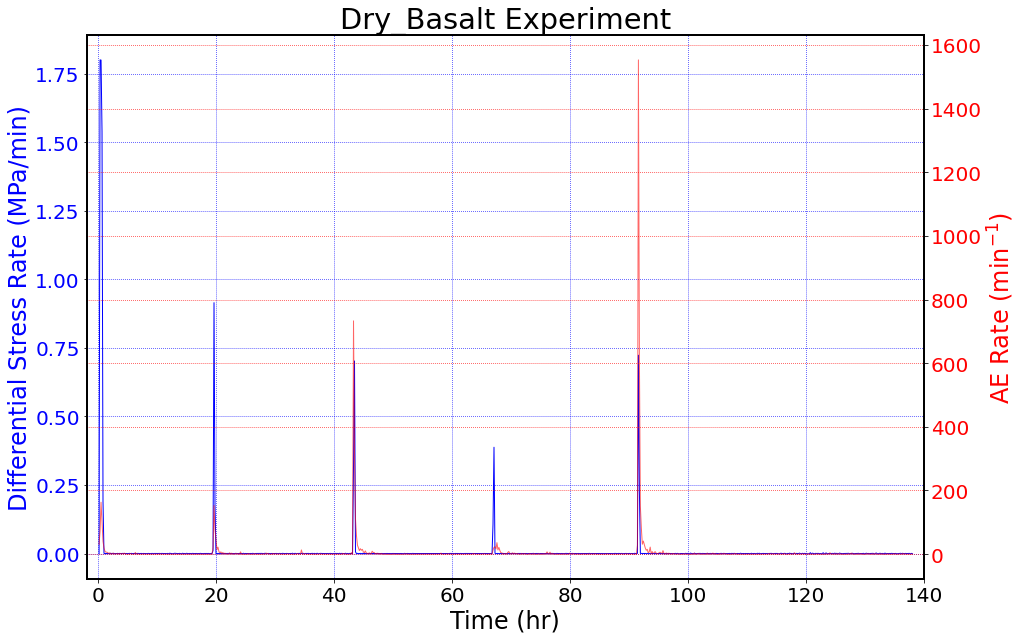

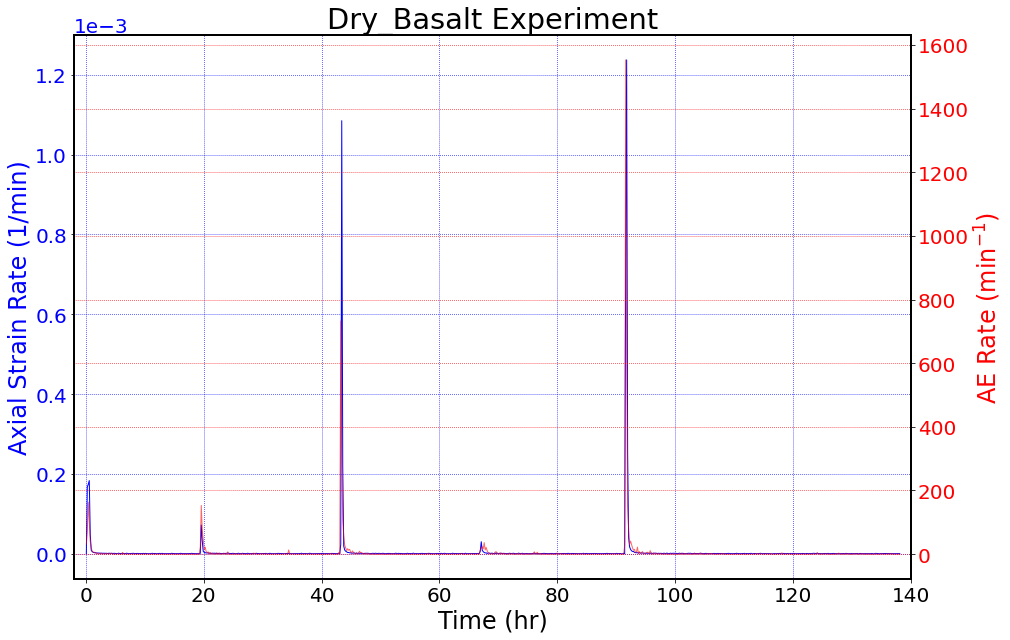

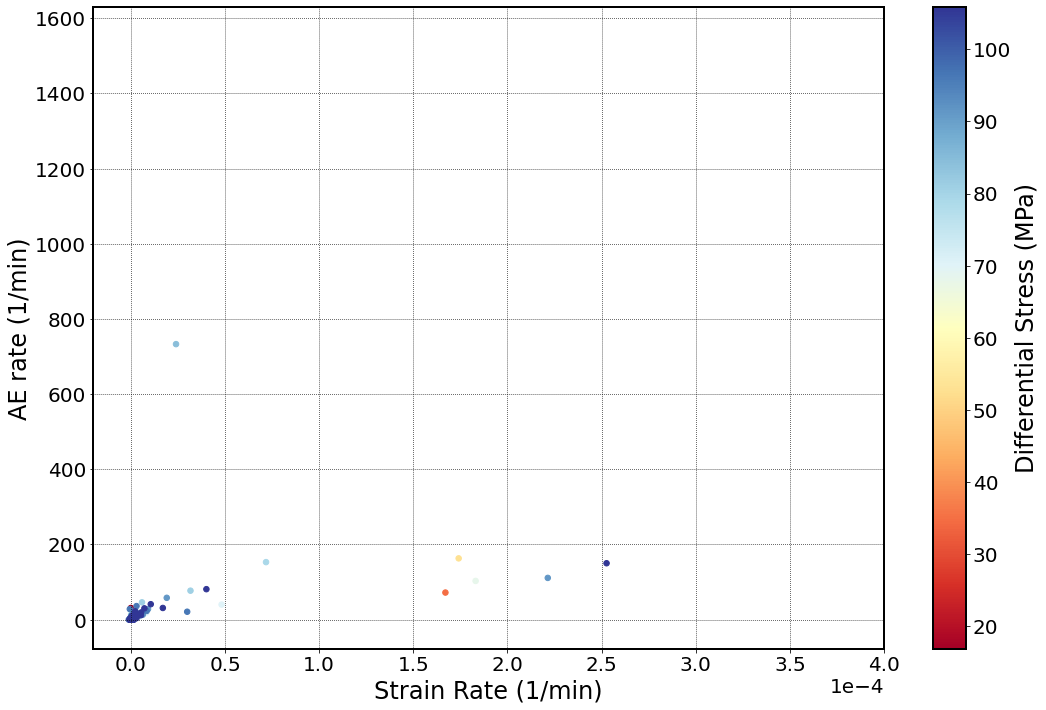

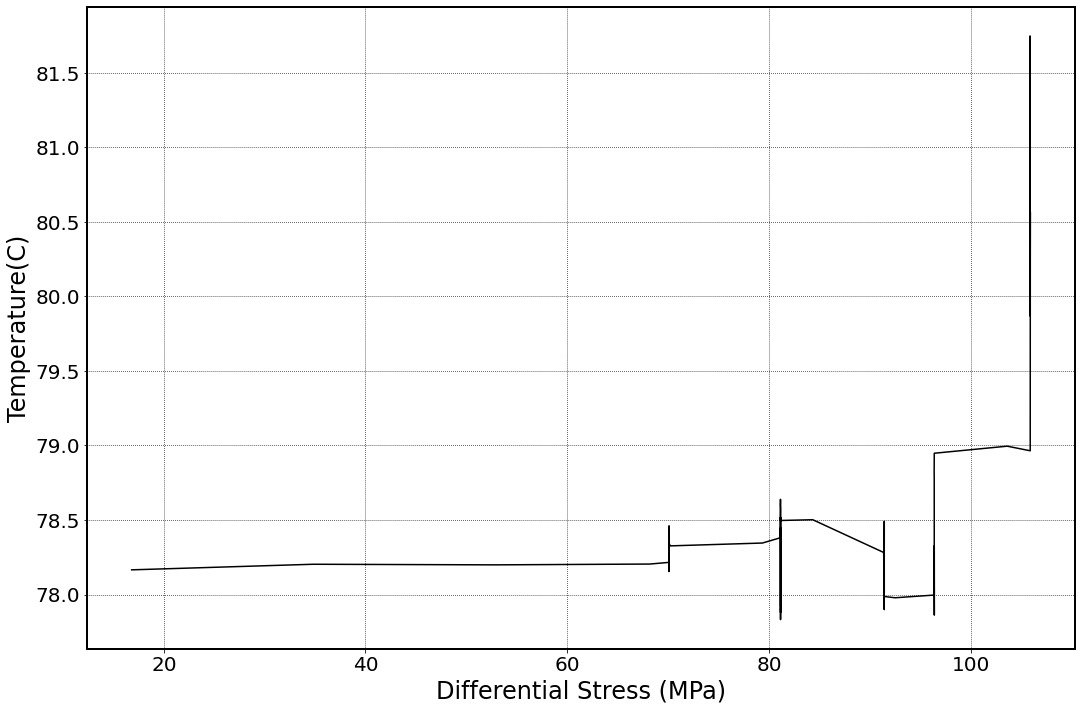

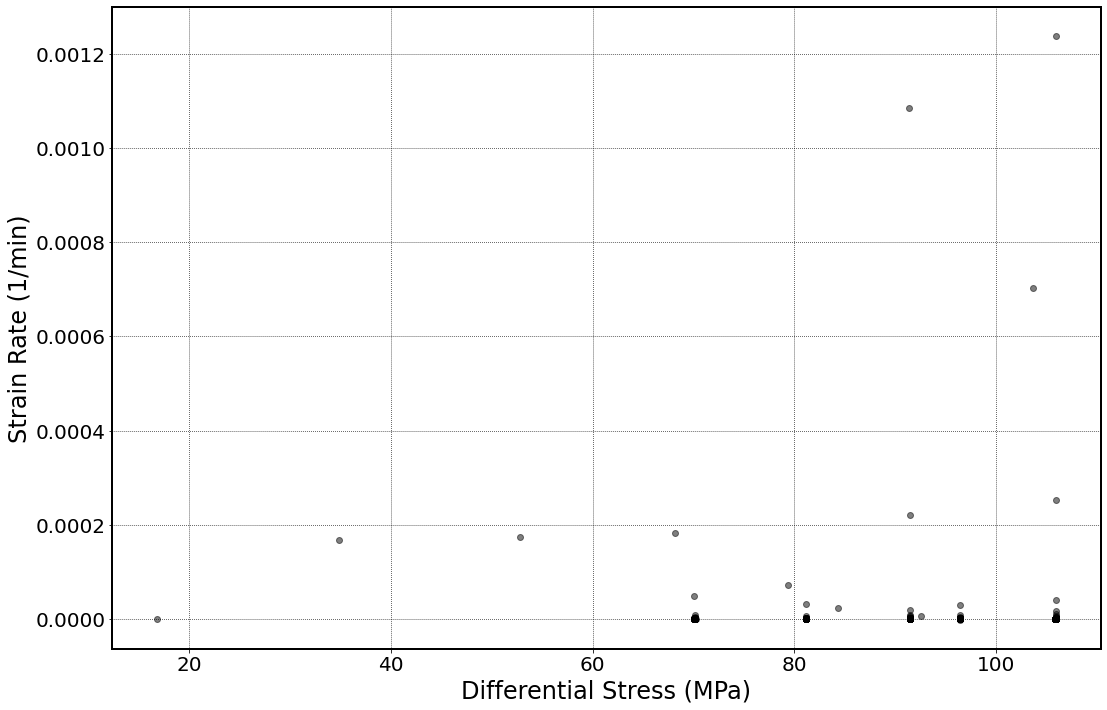

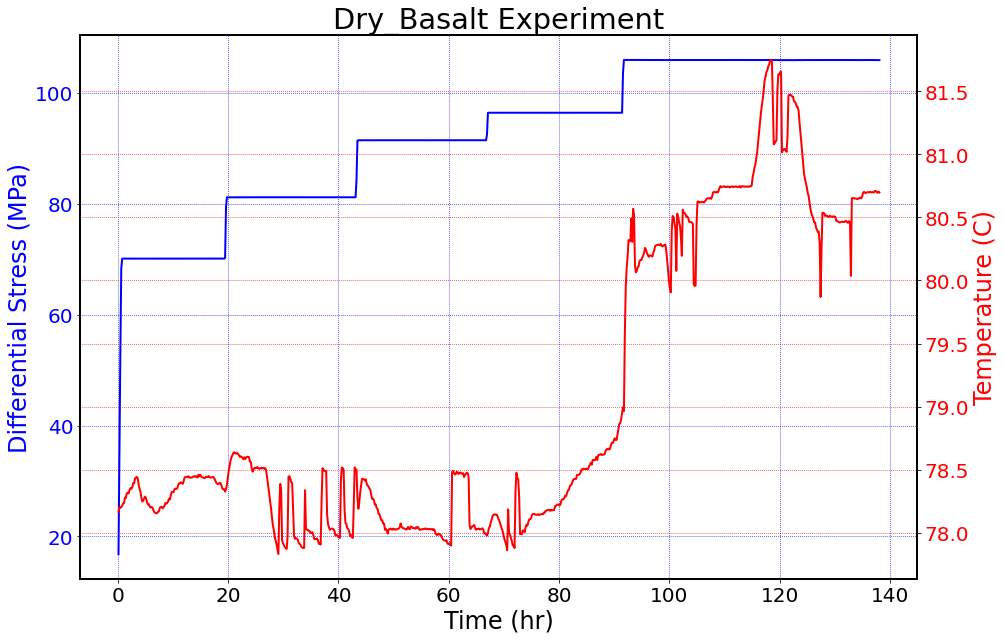

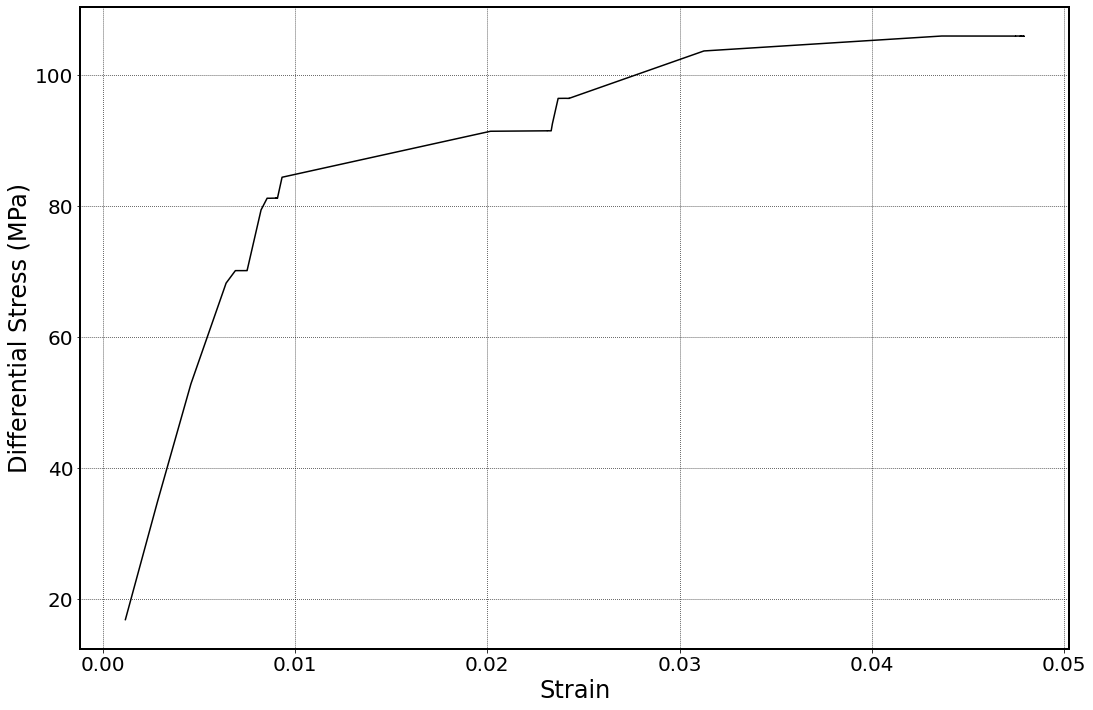

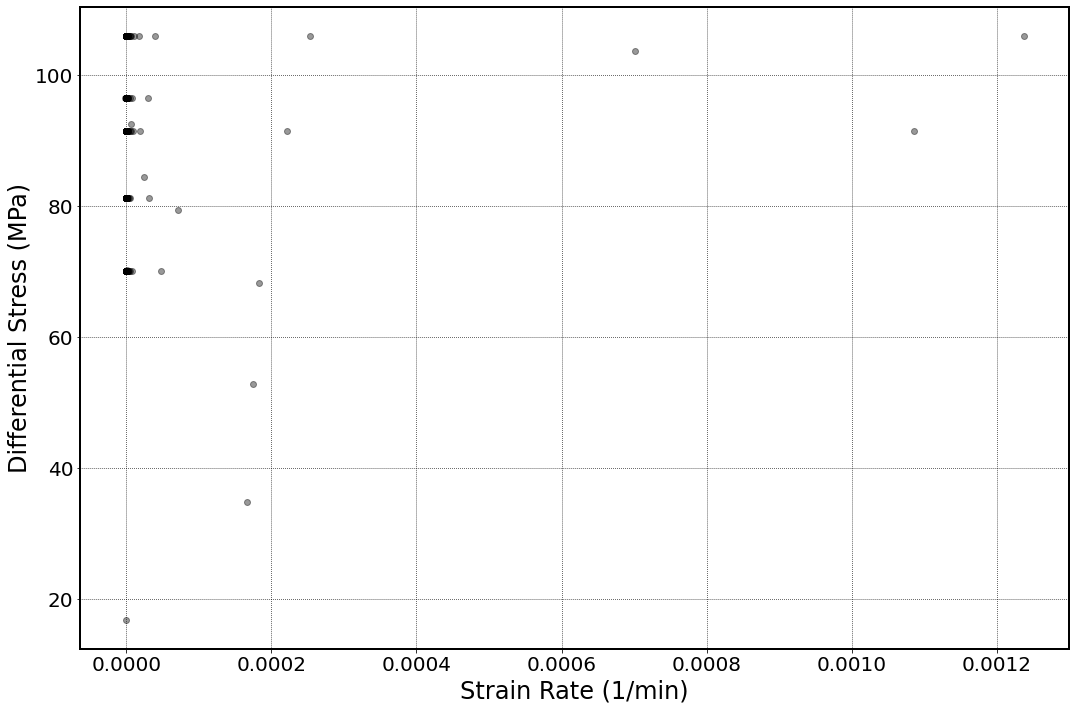

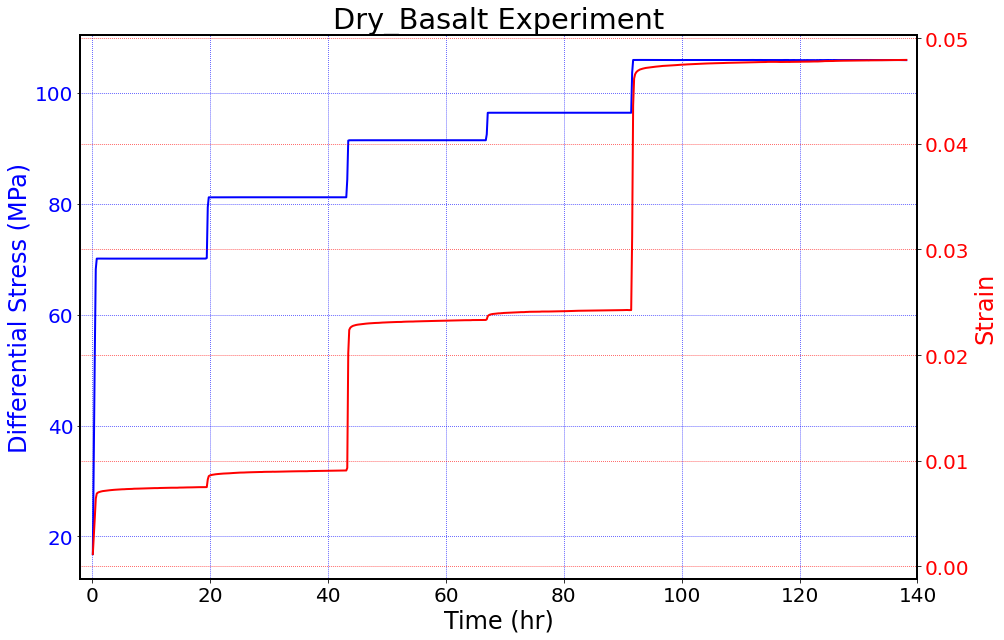

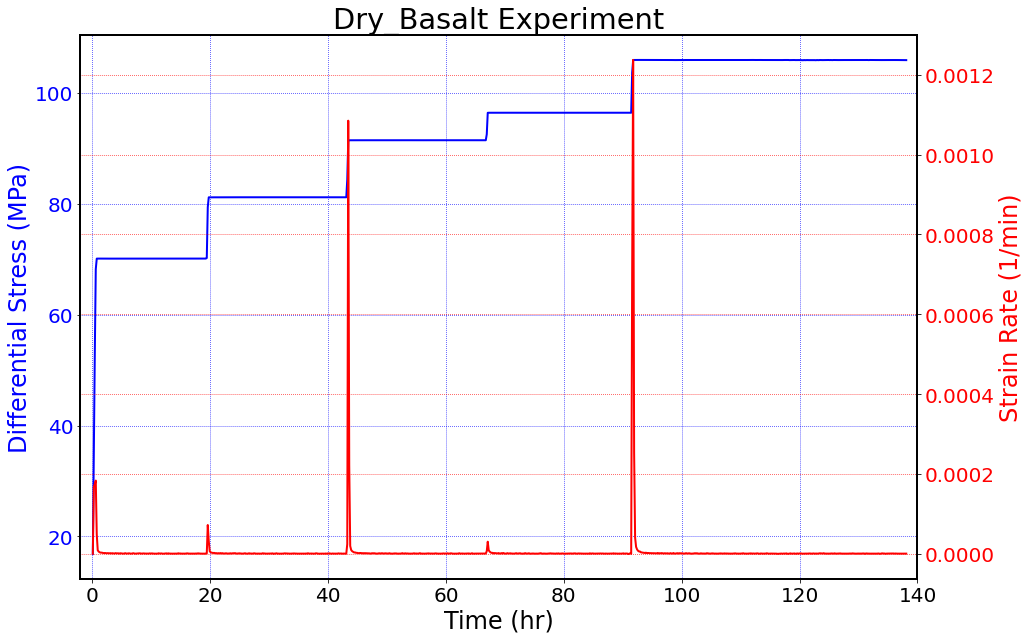

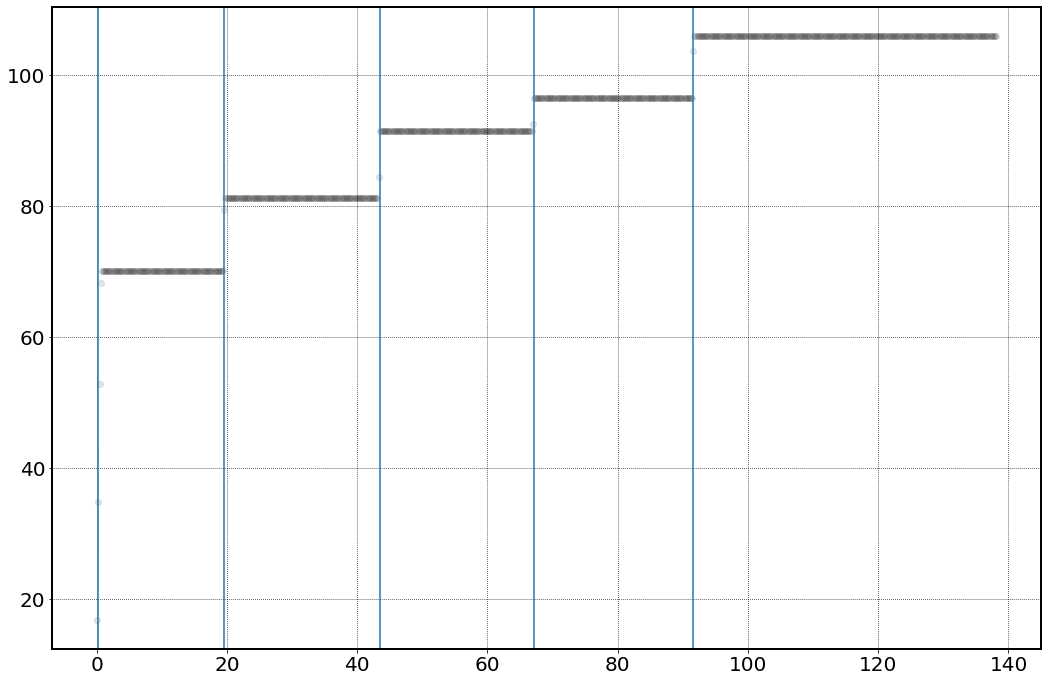

In [29]:
time_window = 600
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
#new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=138.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


In [30]:
plt.close('all')